In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_mask_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 644)
(884582, 3)
validation
(154411, 644)
(154411, 3)
test
(115112, 644)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 644)]             0         


 dense (Dense)               (None, 2048)              1320960   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 4108547 (15.67 MB)


Trainable params: 4108547 (15.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:06 - loss: 1.6337 - STD: 0.2763 - MAE: 0.4780

2/9 [=====>........................] - ETA: 58s - loss: 1.3959 - STD: 0.1969 - MAE: 0.4624 

3/9 [=========>....................] - ETA: 25s - loss: 1.2861 - STD: 0.1662 - MAE: 0.4518

4/9 [============>.................] - ETA: 15s - loss: 1.2374 - STD: 0.1564 - MAE: 0.4456

5/9 [===============>..............] - ETA: 9s - loss: 1.2186 - STD: 0.1572 - MAE: 0.4416 

6/9 [===================>..........] - ETA: 5s - loss: 1.2094 - STD: 0.1594 - MAE: 0.4388

7/9 [======================>.......] - ETA: 3s - loss: 1.2018 - STD: 0.1603 - MAE: 0.4365

8/9 [=========================>....] - ETA: 1s - loss: 1.1942 - STD: 0.1606 - MAE: 0.4346

9/9 [==============================] - ETA: 0s - loss: 1.1867 - STD: 0.1603 - MAE: 0.4331

9/9 [==============================] - 22s 2s/step - loss: 1.1867 - STD: 0.1603 - MAE: 0.4331 - val_loss: 1.1107 - val_STD: 0.1478 - val_MAE: 0.4227


Epoch 2/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.1142 - STD: 0.1478 - MAE: 0.4232

2/9 [=====>........................] - ETA: 2s - loss: 1.1052 - STD: 0.1381 - MAE: 0.4246

3/9 [=========>....................] - ETA: 1s - loss: 1.0956 - STD: 0.1260 - MAE: 0.4262

4/9 [============>.................] - ETA: 1s - loss: 1.0900 - STD: 0.1128 - MAE: 0.4281

5/9 [===============>..............] - ETA: 1s - loss: 1.0874 - STD: 0.0996 - MAE: 0.4300

6/9 [===================>..........] - ETA: 1s - loss: 1.0868 - STD: 0.0873 - MAE: 0.4318

7/9 [======================>.......] - ETA: 0s - loss: 1.0873 - STD: 0.0772 - MAE: 0.4333

8/9 [=========================>....] - ETA: 0s - loss: 1.0879 - STD: 0.0705 - MAE: 0.4344

9/9 [==============================] - ETA: 0s - loss: 1.0884 - STD: 0.0667 - MAE: 0.4352

9/9 [==============================] - 4s 407ms/step - loss: 1.0884 - STD: 0.0667 - MAE: 0.4352 - val_loss: 1.0902 - val_STD: 0.0497 - val_MAE: 0.4399


Epoch 3/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0894 - STD: 0.0498 - MAE: 0.4397

2/9 [=====>........................] - ETA: 2s - loss: 1.0885 - STD: 0.0559 - MAE: 0.4388

3/9 [=========>....................] - ETA: 2s - loss: 1.0871 - STD: 0.0608 - MAE: 0.4380

4/9 [============>.................] - ETA: 1s - loss: 1.0854 - STD: 0.0641 - MAE: 0.4373

5/9 [===============>..............] - ETA: 1s - loss: 1.0836 - STD: 0.0660 - MAE: 0.4366

6/9 [===================>..........] - ETA: 1s - loss: 1.0820 - STD: 0.0672 - MAE: 0.4362

7/9 [======================>.......] - ETA: 0s - loss: 1.0809 - STD: 0.0684 - MAE: 0.4358

8/9 [=========================>....] - ETA: 0s - loss: 1.0803 - STD: 0.0700 - MAE: 0.4354

9/9 [==============================] - ETA: 0s - loss: 1.0800 - STD: 0.0718 - MAE: 0.4351

9/9 [==============================] - 4s 408ms/step - loss: 1.0800 - STD: 0.0718 - MAE: 0.4351 - val_loss: 1.0785 - val_STD: 0.0913 - val_MAE: 0.4319


Epoch 4/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0796 - STD: 0.0913 - MAE: 0.4320

2/9 [=====>........................] - ETA: 2s - loss: 1.0790 - STD: 0.0930 - MAE: 0.4315

3/9 [=========>....................] - ETA: 2s - loss: 1.0793 - STD: 0.0945 - MAE: 0.4312

4/9 [============>.................] - ETA: 1s - loss: 1.0786 - STD: 0.0957 - MAE: 0.4308

5/9 [===============>..............] - ETA: 1s - loss: 1.0783 - STD: 0.0965 - MAE: 0.4306

6/9 [===================>..........] - ETA: 1s - loss: 1.0779 - STD: 0.0966 - MAE: 0.4305

7/9 [======================>.......] - ETA: 0s - loss: 1.0775 - STD: 0.0959 - MAE: 0.4306

8/9 [=========================>....] - ETA: 0s - loss: 1.0772 - STD: 0.0944 - MAE: 0.4308

9/9 [==============================] - ETA: 0s - loss: 1.0767 - STD: 0.0922 - MAE: 0.4311

9/9 [==============================] - 4s 406ms/step - loss: 1.0767 - STD: 0.0922 - MAE: 0.4311 - val_loss: 1.0732 - val_STD: 0.0659 - val_MAE: 0.4347


Epoch 5/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0741 - STD: 0.0659 - MAE: 0.4349

2/9 [=====>........................] - ETA: 2s - loss: 1.0740 - STD: 0.0626 - MAE: 0.4352

3/9 [=========>....................] - ETA: 2s - loss: 1.0744 - STD: 0.0602 - MAE: 0.4356

4/9 [============>.................] - ETA: 1s - loss: 1.0744 - STD: 0.0588 - MAE: 0.4358

5/9 [===============>..............] - ETA: 1s - loss: 1.0744 - STD: 0.0584 - MAE: 0.4358

6/9 [===================>..........] - ETA: 1s - loss: 1.0745 - STD: 0.0589 - MAE: 0.4358

7/9 [======================>.......] - ETA: 0s - loss: 1.0746 - STD: 0.0600 - MAE: 0.4357

8/9 [=========================>....] - ETA: 0s - loss: 1.0745 - STD: 0.0612 - MAE: 0.4355

9/9 [==============================] - ETA: 0s - loss: 1.0743 - STD: 0.0625 - MAE: 0.4353

9/9 [==============================] - 4s 405ms/step - loss: 1.0743 - STD: 0.0625 - MAE: 0.4353 - val_loss: 1.0728 - val_STD: 0.0734 - val_MAE: 0.4336


Epoch 6/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0731 - STD: 0.0735 - MAE: 0.4336

2/9 [=====>........................] - ETA: 2s - loss: 1.0736 - STD: 0.0736 - MAE: 0.4337

3/9 [=========>....................] - ETA: 1s - loss: 1.0734 - STD: 0.0736 - MAE: 0.4336

4/9 [============>.................] - ETA: 1s - loss: 1.0730 - STD: 0.0736 - MAE: 0.4335

5/9 [===============>..............] - ETA: 1s - loss: 1.0727 - STD: 0.0739 - MAE: 0.4334

6/9 [===================>..........] - ETA: 1s - loss: 1.0729 - STD: 0.0745 - MAE: 0.4334

7/9 [======================>.......] - ETA: 0s - loss: 1.0730 - STD: 0.0752 - MAE: 0.4333

8/9 [=========================>....] - ETA: 0s - loss: 1.0728 - STD: 0.0759 - MAE: 0.4331

9/9 [==============================] - ETA: 0s - loss: 1.0726 - STD: 0.0767 - MAE: 0.4329

9/9 [==============================] - 4s 409ms/step - loss: 1.0726 - STD: 0.0767 - MAE: 0.4329 - val_loss: 1.0708 - val_STD: 0.0819 - val_MAE: 0.4318


Epoch 7/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0712 - STD: 0.0821 - MAE: 0.4317

2/9 [=====>........................] - ETA: 2s - loss: 1.0713 - STD: 0.0810 - MAE: 0.4319

3/9 [=========>....................] - ETA: 2s - loss: 1.0708 - STD: 0.0793 - MAE: 0.4321

4/9 [============>.................] - ETA: 1s - loss: 1.0702 - STD: 0.0776 - MAE: 0.4322

5/9 [===============>..............] - ETA: 1s - loss: 1.0699 - STD: 0.0761 - MAE: 0.4323

6/9 [===================>..........] - ETA: 1s - loss: 1.0693 - STD: 0.0749 - MAE: 0.4324

7/9 [======================>.......] - ETA: 0s - loss: 1.0688 - STD: 0.0739 - MAE: 0.4324

8/9 [=========================>....] - ETA: 0s - loss: 1.0682 - STD: 0.0730 - MAE: 0.4323

9/9 [==============================] - ETA: 0s - loss: 1.0674 - STD: 0.0725 - MAE: 0.4322

9/9 [==============================] - 4s 406ms/step - loss: 1.0674 - STD: 0.0725 - MAE: 0.4322 - val_loss: 1.0591 - val_STD: 0.0687 - val_MAE: 0.4308


Epoch 8/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0592 - STD: 0.0699 - MAE: 0.4306

2/9 [=====>........................] - ETA: 2s - loss: 1.0567 - STD: 0.0710 - MAE: 0.4298

3/9 [=========>....................] - ETA: 2s - loss: 1.0550 - STD: 0.0719 - MAE: 0.4292

4/9 [============>.................] - ETA: 1s - loss: 1.0528 - STD: 0.0723 - MAE: 0.4286

5/9 [===============>..............] - ETA: 1s - loss: 1.0503 - STD: 0.0726 - MAE: 0.4278

6/9 [===================>..........] - ETA: 1s - loss: 1.0472 - STD: 0.0732 - MAE: 0.4270

7/9 [======================>.......] - ETA: 0s - loss: 1.0436 - STD: 0.0737 - MAE: 0.4260

8/9 [=========================>....] - ETA: 0s - loss: 1.0395 - STD: 0.0746 - MAE: 0.4249

9/9 [==============================] - ETA: 0s - loss: 1.0351 - STD: 0.0756 - MAE: 0.4236

9/9 [==============================] - 4s 408ms/step - loss: 1.0351 - STD: 0.0756 - MAE: 0.4236 - val_loss: 0.9885 - val_STD: 0.0857 - val_MAE: 0.4104


Epoch 9/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.9836 - STD: 0.0905 - MAE: 0.4081

2/9 [=====>........................] - ETA: 2s - loss: 0.9741 - STD: 0.0927 - MAE: 0.4054

3/9 [=========>....................] - ETA: 2s - loss: 0.9641 - STD: 0.0981 - MAE: 0.4019

4/9 [============>.................] - ETA: 1s - loss: 0.9555 - STD: 0.1002 - MAE: 0.3995

5/9 [===============>..............] - ETA: 1s - loss: 0.9463 - STD: 0.1088 - MAE: 0.3951

6/9 [===================>..........] - ETA: 1s - loss: 0.9349 - STD: 0.1146 - MAE: 0.3911

7/9 [======================>.......] - ETA: 0s - loss: 0.9253 - STD: 0.1194 - MAE: 0.3878

8/9 [=========================>....] - ETA: 0s - loss: 0.9167 - STD: 0.1284 - MAE: 0.3829

9/9 [==============================] - ETA: 0s - loss: 0.9056 - STD: 0.1364 - MAE: 0.3780

9/9 [==============================] - 4s 407ms/step - loss: 0.9056 - STD: 0.1364 - MAE: 0.3780 - val_loss: 0.8810 - val_STD: 0.1956 - val_MAE: 0.3563


Epoch 10/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8191 - STD: 0.1994 - MAE: 0.3412

2/9 [=====>........................] - ETA: 2s - loss: 0.8083 - STD: 0.2181 - MAE: 0.3306

3/9 [=========>....................] - ETA: 1s - loss: 0.8004 - STD: 0.2285 - MAE: 0.3247

4/9 [============>.................] - ETA: 1s - loss: 0.7986 - STD: 0.2314 - MAE: 0.3232

5/9 [===============>..............] - ETA: 1s - loss: 0.7929 - STD: 0.2381 - MAE: 0.3190

6/9 [===================>..........] - ETA: 1s - loss: 0.7891 - STD: 0.2442 - MAE: 0.3153

7/9 [======================>.......] - ETA: 0s - loss: 0.7848 - STD: 0.2461 - MAE: 0.3137

8/9 [=========================>....] - ETA: 0s - loss: 0.7793 - STD: 0.2481 - MAE: 0.3118

9/9 [==============================] - ETA: 0s - loss: 0.7751 - STD: 0.2500 - MAE: 0.3101

9/9 [==============================] - 4s 412ms/step - loss: 0.7751 - STD: 0.2500 - MAE: 0.3101 - val_loss: 0.7826 - val_STD: 0.2318 - val_MAE: 0.3216


Epoch 11/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.7361 - STD: 0.2390 - MAE: 0.3087

2/9 [=====>........................] - ETA: 2s - loss: 0.7328 - STD: 0.2389 - MAE: 0.3078

3/9 [=========>....................] - ETA: 1s - loss: 0.7325 - STD: 0.2432 - MAE: 0.3055

4/9 [============>.................] - ETA: 1s - loss: 0.7312 - STD: 0.2432 - MAE: 0.3054

5/9 [===============>..............] - ETA: 1s - loss: 0.7273 - STD: 0.2476 - MAE: 0.3024

6/9 [===================>..........] - ETA: 1s - loss: 0.7242 - STD: 0.2531 - MAE: 0.2990

7/9 [======================>.......] - ETA: 0s - loss: 0.7225 - STD: 0.2568 - MAE: 0.2969

8/9 [=========================>....] - ETA: 0s - loss: 0.7207 - STD: 0.2613 - MAE: 0.2942

9/9 [==============================] - ETA: 0s - loss: 0.7185 - STD: 0.2636 - MAE: 0.2926

9/9 [==============================] - 4s 420ms/step - loss: 0.7185 - STD: 0.2636 - MAE: 0.2926 - val_loss: 0.7306 - val_STD: 0.2702 - val_MAE: 0.2925


Epoch 12/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.7006 - STD: 0.2722 - MAE: 0.2850

2/9 [=====>........................] - ETA: 2s - loss: 0.6998 - STD: 0.2738 - MAE: 0.2837

3/9 [=========>....................] - ETA: 1s - loss: 0.6983 - STD: 0.2687 - MAE: 0.2861

4/9 [============>.................] - ETA: 1s - loss: 0.6957 - STD: 0.2694 - MAE: 0.2851

5/9 [===============>..............] - ETA: 1s - loss: 0.6928 - STD: 0.2704 - MAE: 0.2840

6/9 [===================>..........] - ETA: 1s - loss: 0.6914 - STD: 0.2721 - MAE: 0.2829

7/9 [======================>.......] - ETA: 0s - loss: 0.6903 - STD: 0.2754 - MAE: 0.2808

8/9 [=========================>....] - ETA: 0s - loss: 0.6894 - STD: 0.2767 - MAE: 0.2799

9/9 [==============================] - ETA: 0s - loss: 0.6882 - STD: 0.2785 - MAE: 0.2787

9/9 [==============================] - 4s 419ms/step - loss: 0.6882 - STD: 0.2785 - MAE: 0.2787 - val_loss: 0.7025 - val_STD: 0.2791 - val_MAE: 0.2817


Epoch 13/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6737 - STD: 0.2795 - MAE: 0.2753

2/9 [=====>........................] - ETA: 2s - loss: 0.6721 - STD: 0.2779 - MAE: 0.2759

3/9 [=========>....................] - ETA: 1s - loss: 0.6716 - STD: 0.2787 - MAE: 0.2753

4/9 [============>.................] - ETA: 1s - loss: 0.6712 - STD: 0.2785 - MAE: 0.2754

5/9 [===============>..............] - ETA: 1s - loss: 0.6698 - STD: 0.2814 - MAE: 0.2734

6/9 [===================>..........] - ETA: 1s - loss: 0.6688 - STD: 0.2830 - MAE: 0.2724

7/9 [======================>.......] - ETA: 0s - loss: 0.6672 - STD: 0.2856 - MAE: 0.2706

8/9 [=========================>....] - ETA: 0s - loss: 0.6661 - STD: 0.2863 - MAE: 0.2700

9/9 [==============================] - ETA: 0s - loss: 0.6647 - STD: 0.2873 - MAE: 0.2691

9/9 [==============================] - 4s 409ms/step - loss: 0.6647 - STD: 0.2873 - MAE: 0.2691 - val_loss: 0.6781 - val_STD: 0.2857 - val_MAE: 0.2733


Epoch 14/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6519 - STD: 0.2837 - MAE: 0.2686

2/9 [=====>........................] - ETA: 2s - loss: 0.6521 - STD: 0.2877 - MAE: 0.2659

3/9 [=========>....................] - ETA: 2s - loss: 0.6515 - STD: 0.2874 - MAE: 0.2663

4/9 [============>.................] - ETA: 1s - loss: 0.6501 - STD: 0.2910 - MAE: 0.2638

5/9 [===============>..............] - ETA: 1s - loss: 0.6499 - STD: 0.2920 - MAE: 0.2633

6/9 [===================>..........] - ETA: 1s - loss: 0.6486 - STD: 0.2944 - MAE: 0.2615

7/9 [======================>.......] - ETA: 0s - loss: 0.6471 - STD: 0.2947 - MAE: 0.2611

8/9 [=========================>....] - ETA: 0s - loss: 0.6455 - STD: 0.2948 - MAE: 0.2607

9/9 [==============================] - ETA: 0s - loss: 0.6438 - STD: 0.2943 - MAE: 0.2606

9/9 [==============================] - 4s 408ms/step - loss: 0.6438 - STD: 0.2943 - MAE: 0.2606 - val_loss: 0.6392 - val_STD: 0.2929 - val_MAE: 0.2610


Epoch 15/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6262 - STD: 0.2915 - MAE: 0.2585

2/9 [=====>........................] - ETA: 2s - loss: 0.6242 - STD: 0.2948 - MAE: 0.2559

3/9 [=========>....................] - ETA: 1s - loss: 0.6248 - STD: 0.2972 - MAE: 0.2550

4/9 [============>.................] - ETA: 1s - loss: 0.6290 - STD: 0.3011 - MAE: 0.2531

5/9 [===============>..............] - ETA: 1s - loss: 0.6414 - STD: 0.3017 - MAE: 0.2555

6/9 [===================>..........] - ETA: 1s - loss: 0.6506 - STD: 0.3045 - MAE: 0.2552

7/9 [======================>.......] - ETA: 0s - loss: 0.6449 - STD: 0.3047 - MAE: 0.2540

8/9 [=========================>....] - ETA: 0s - loss: 0.6471 - STD: 0.3042 - MAE: 0.2550

9/9 [==============================] - ETA: 0s - loss: 0.6480 - STD: 0.3045 - MAE: 0.2547

9/9 [==============================] - 4s 408ms/step - loss: 0.6480 - STD: 0.3045 - MAE: 0.2547 - val_loss: 0.6106 - val_STD: 0.3025 - val_MAE: 0.2486


Epoch 16/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6140 - STD: 0.3042 - MAE: 0.2473

2/9 [=====>........................] - ETA: 2s - loss: 0.6367 - STD: 0.3023 - MAE: 0.2542

3/9 [=========>....................] - ETA: 2s - loss: 0.6266 - STD: 0.3037 - MAE: 0.2510

4/9 [============>.................] - ETA: 1s - loss: 0.6294 - STD: 0.3060 - MAE: 0.2497

5/9 [===============>..............] - ETA: 1s - loss: 0.6264 - STD: 0.3065 - MAE: 0.2491

6/9 [===================>..........] - ETA: 1s - loss: 0.6253 - STD: 0.3068 - MAE: 0.2489

7/9 [======================>.......] - ETA: 0s - loss: 0.6242 - STD: 0.3071 - MAE: 0.2482

8/9 [=========================>....] - ETA: 0s - loss: 0.6217 - STD: 0.3071 - MAE: 0.2476

9/9 [==============================] - ETA: 0s - loss: 0.6212 - STD: 0.3067 - MAE: 0.2480

9/9 [==============================] - 4s 412ms/step - loss: 0.6212 - STD: 0.3067 - MAE: 0.2480 - val_loss: 0.6122 - val_STD: 0.3069 - val_MAE: 0.2477


Epoch 17/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5952 - STD: 0.3056 - MAE: 0.2439

2/9 [=====>........................] - ETA: 2s - loss: 0.6047 - STD: 0.3079 - MAE: 0.2435

3/9 [=========>....................] - ETA: 2s - loss: 0.6010 - STD: 0.3092 - MAE: 0.2421

4/9 [============>.................] - ETA: 1s - loss: 0.6025 - STD: 0.3097 - MAE: 0.2424

5/9 [===============>..............] - ETA: 1s - loss: 0.6001 - STD: 0.3103 - MAE: 0.2415

6/9 [===================>..........] - ETA: 1s - loss: 0.6001 - STD: 0.3104 - MAE: 0.2412

7/9 [======================>.......] - ETA: 0s - loss: 0.5994 - STD: 0.3105 - MAE: 0.2412

8/9 [=========================>....] - ETA: 0s - loss: 0.5975 - STD: 0.3104 - MAE: 0.2409

9/9 [==============================] - ETA: 0s - loss: 0.5974 - STD: 0.3104 - MAE: 0.2407

9/9 [==============================] - 4s 406ms/step - loss: 0.5974 - STD: 0.3104 - MAE: 0.2407 - val_loss: 0.5871 - val_STD: 0.3129 - val_MAE: 0.2386


Epoch 18/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5850 - STD: 0.3121 - MAE: 0.2371

2/9 [=====>........................] - ETA: 2s - loss: 0.5878 - STD: 0.3137 - MAE: 0.2371

3/9 [=========>....................] - ETA: 2s - loss: 0.5869 - STD: 0.3142 - MAE: 0.2362

4/9 [============>.................] - ETA: 1s - loss: 0.5858 - STD: 0.3146 - MAE: 0.2356

5/9 [===============>..............] - ETA: 1s - loss: 0.5855 - STD: 0.3152 - MAE: 0.2353

6/9 [===================>..........] - ETA: 1s - loss: 0.5837 - STD: 0.3154 - MAE: 0.2347

7/9 [======================>.......] - ETA: 0s - loss: 0.5833 - STD: 0.3155 - MAE: 0.2344

8/9 [=========================>....] - ETA: 0s - loss: 0.5829 - STD: 0.3158 - MAE: 0.2342

9/9 [==============================] - ETA: 0s - loss: 0.5817 - STD: 0.3161 - MAE: 0.2338

9/9 [==============================] - 4s 421ms/step - loss: 0.5817 - STD: 0.3161 - MAE: 0.2338 - val_loss: 0.5584 - val_STD: 0.3177 - val_MAE: 0.2288


Epoch 19/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5753 - STD: 0.3193 - MAE: 0.2296

2/9 [=====>........................] - ETA: 2s - loss: 0.5729 - STD: 0.3203 - MAE: 0.2290

3/9 [=========>....................] - ETA: 1s - loss: 0.5727 - STD: 0.3208 - MAE: 0.2287

4/9 [============>.................] - ETA: 1s - loss: 0.5727 - STD: 0.3209 - MAE: 0.2286

5/9 [===============>..............] - ETA: 1s - loss: 0.5710 - STD: 0.3212 - MAE: 0.2281

6/9 [===================>..........] - ETA: 1s - loss: 0.5704 - STD: 0.3211 - MAE: 0.2281

7/9 [======================>.......] - ETA: 0s - loss: 0.5701 - STD: 0.3210 - MAE: 0.2280

8/9 [=========================>....] - ETA: 0s - loss: 0.5689 - STD: 0.3212 - MAE: 0.2277

9/9 [==============================] - ETA: 0s - loss: 0.5679 - STD: 0.3216 - MAE: 0.2273

9/9 [==============================] - 4s 407ms/step - loss: 0.5679 - STD: 0.3216 - MAE: 0.2273 - val_loss: 0.5457 - val_STD: 0.3236 - val_MAE: 0.2228


Epoch 20/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5588 - STD: 0.3252 - MAE: 0.2226

2/9 [=====>........................] - ETA: 2s - loss: 0.5612 - STD: 0.3258 - MAE: 0.2229

3/9 [=========>....................] - ETA: 2s - loss: 0.5599 - STD: 0.3258 - MAE: 0.2227

4/9 [============>.................] - ETA: 1s - loss: 0.5580 - STD: 0.3256 - MAE: 0.2225

5/9 [===============>..............] - ETA: 1s - loss: 0.5573 - STD: 0.3257 - MAE: 0.2224

6/9 [===================>..........] - ETA: 1s - loss: 0.5563 - STD: 0.3258 - MAE: 0.2220

7/9 [======================>.......] - ETA: 0s - loss: 0.5553 - STD: 0.3262 - MAE: 0.2215

8/9 [=========================>....] - ETA: 0s - loss: 0.5550 - STD: 0.3267 - MAE: 0.2212

9/9 [==============================] - ETA: 0s - loss: 0.5539 - STD: 0.3270 - MAE: 0.2208

9/9 [==============================] - 4s 408ms/step - loss: 0.5539 - STD: 0.3270 - MAE: 0.2208 - val_loss: 0.5482 - val_STD: 0.3293 - val_MAE: 0.2203


Epoch 21/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5466 - STD: 0.3299 - MAE: 0.2172

2/9 [=====>........................] - ETA: 2s - loss: 0.5438 - STD: 0.3298 - MAE: 0.2169

3/9 [=========>....................] - ETA: 2s - loss: 0.5436 - STD: 0.3299 - MAE: 0.2167

4/9 [============>.................] - ETA: 1s - loss: 0.5432 - STD: 0.3304 - MAE: 0.2162

5/9 [===============>..............] - ETA: 1s - loss: 0.5439 - STD: 0.3310 - MAE: 0.2160

6/9 [===================>..........] - ETA: 1s - loss: 0.5435 - STD: 0.3313 - MAE: 0.2157

7/9 [======================>.......] - ETA: 0s - loss: 0.5433 - STD: 0.3315 - MAE: 0.2155

8/9 [=========================>....] - ETA: 0s - loss: 0.5426 - STD: 0.3315 - MAE: 0.2153

9/9 [==============================] - ETA: 0s - loss: 0.5419 - STD: 0.3318 - MAE: 0.2149

9/9 [==============================] - 4s 405ms/step - loss: 0.5419 - STD: 0.3318 - MAE: 0.2149 - val_loss: 0.5196 - val_STD: 0.3327 - val_MAE: 0.2116


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5352 - STD: 0.3343 - MAE: 0.2118

2/9 [=====>........................] - ETA: 2s - loss: 0.5374 - STD: 0.3359 - MAE: 0.2113

3/9 [=========>....................] - ETA: 2s - loss: 0.5400 - STD: 0.3353 - MAE: 0.2120

4/9 [============>.................] - ETA: 1s - loss: 0.5431 - STD: 0.3363 - MAE: 0.2122

5/9 [===============>..............] - ETA: 1s - loss: 0.5506 - STD: 0.3352 - MAE: 0.2143

6/9 [===================>..........] - ETA: 1s - loss: 0.5538 - STD: 0.3358 - MAE: 0.2146

7/9 [======================>.......] - ETA: 0s - loss: 0.5535 - STD: 0.3355 - MAE: 0.2147

8/9 [=========================>....] - ETA: 0s - loss: 0.5504 - STD: 0.3356 - MAE: 0.2140

9/9 [==============================] - ETA: 0s - loss: 0.5503 - STD: 0.3363 - MAE: 0.2136

9/9 [==============================] - 4s 419ms/step - loss: 0.5503 - STD: 0.3363 - MAE: 0.2136 - val_loss: 0.5134 - val_STD: 0.3331 - val_MAE: 0.2090


Epoch 23/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5619 - STD: 0.3368 - MAE: 0.2151

2/9 [=====>........................] - ETA: 2s - loss: 0.5481 - STD: 0.3376 - MAE: 0.2117

3/9 [=========>....................] - ETA: 1s - loss: 0.5451 - STD: 0.3377 - MAE: 0.2114

4/9 [============>.................] - ETA: 1s - loss: 0.5456 - STD: 0.3367 - MAE: 0.2122

5/9 [===============>..............] - ETA: 1s - loss: 0.5404 - STD: 0.3369 - MAE: 0.2111

6/9 [===================>..........] - ETA: 1s - loss: 0.5406 - STD: 0.3374 - MAE: 0.2110

7/9 [======================>.......] - ETA: 0s - loss: 0.5417 - STD: 0.3374 - MAE: 0.2111

8/9 [=========================>....] - ETA: 0s - loss: 0.5394 - STD: 0.3376 - MAE: 0.2105

9/9 [==============================] - ETA: 0s - loss: 0.5391 - STD: 0.3380 - MAE: 0.2102

9/9 [==============================] - 4s 420ms/step - loss: 0.5391 - STD: 0.3380 - MAE: 0.2102 - val_loss: 0.5018 - val_STD: 0.3331 - val_MAE: 0.2071


Epoch 24/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5499 - STD: 0.3353 - MAE: 0.2142

2/9 [=====>........................] - ETA: 2s - loss: 0.5357 - STD: 0.3367 - MAE: 0.2103

3/9 [=========>....................] - ETA: 2s - loss: 0.5351 - STD: 0.3385 - MAE: 0.2092

4/9 [============>.................] - ETA: 1s - loss: 0.5365 - STD: 0.3386 - MAE: 0.2093

5/9 [===============>..............] - ETA: 1s - loss: 0.5310 - STD: 0.3395 - MAE: 0.2076

6/9 [===================>..........] - ETA: 1s - loss: 0.5323 - STD: 0.3405 - MAE: 0.2072

7/9 [======================>.......] - ETA: 0s - loss: 0.5345 - STD: 0.3403 - MAE: 0.2076

8/9 [=========================>....] - ETA: 0s - loss: 0.5323 - STD: 0.3405 - MAE: 0.2070

9/9 [==============================] - ETA: 0s - loss: 0.5338 - STD: 0.3410 - MAE: 0.2069

9/9 [==============================] - 4s 405ms/step - loss: 0.5338 - STD: 0.3410 - MAE: 0.2069 - val_loss: 0.4963 - val_STD: 0.3366 - val_MAE: 0.2033


Epoch 25/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5425 - STD: 0.3398 - MAE: 0.2093

2/9 [=====>........................] - ETA: 2s - loss: 0.5256 - STD: 0.3414 - MAE: 0.2049

3/9 [=========>....................] - ETA: 2s - loss: 0.5357 - STD: 0.3436 - MAE: 0.2053

4/9 [============>.................] - ETA: 1s - loss: 0.5365 - STD: 0.3430 - MAE: 0.2059

5/9 [===============>..............] - ETA: 1s - loss: 0.5330 - STD: 0.3427 - MAE: 0.2055

6/9 [===================>..........] - ETA: 1s - loss: 0.5374 - STD: 0.3433 - MAE: 0.2059

7/9 [======================>.......] - ETA: 0s - loss: 0.5347 - STD: 0.3429 - MAE: 0.2056

8/9 [=========================>....] - ETA: 0s - loss: 0.5338 - STD: 0.3427 - MAE: 0.2055

9/9 [==============================] - ETA: 0s - loss: 0.5331 - STD: 0.3431 - MAE: 0.2052

9/9 [==============================] - 4s 401ms/step - loss: 0.5331 - STD: 0.3431 - MAE: 0.2052 - val_loss: 0.5114 - val_STD: 0.3431 - val_MAE: 0.2035


Epoch 26/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5070 - STD: 0.3456 - MAE: 0.1984

2/9 [=====>........................] - ETA: 2s - loss: 0.5181 - STD: 0.3448 - MAE: 0.2010

3/9 [=========>....................] - ETA: 2s - loss: 0.5138 - STD: 0.3451 - MAE: 0.2000

4/9 [============>.................] - ETA: 1s - loss: 0.5149 - STD: 0.3455 - MAE: 0.2000

5/9 [===============>..............] - ETA: 1s - loss: 0.5144 - STD: 0.3450 - MAE: 0.2003

6/9 [===================>..........] - ETA: 1s - loss: 0.5129 - STD: 0.3449 - MAE: 0.2000

7/9 [======================>.......] - ETA: 0s - loss: 0.5143 - STD: 0.3455 - MAE: 0.1999

8/9 [=========================>....] - ETA: 0s - loss: 0.5125 - STD: 0.3456 - MAE: 0.1994

9/9 [==============================] - ETA: 0s - loss: 0.5123 - STD: 0.3457 - MAE: 0.1993

9/9 [==============================] - 4s 414ms/step - loss: 0.5123 - STD: 0.3457 - MAE: 0.1993 - val_loss: 0.5235 - val_STD: 0.3474 - val_MAE: 0.2032


Epoch 27/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5096 - STD: 0.3496 - MAE: 0.1959

2/9 [=====>........................] - ETA: 2s - loss: 0.5041 - STD: 0.3493 - MAE: 0.1951

3/9 [=========>....................] - ETA: 2s - loss: 0.5037 - STD: 0.3484 - MAE: 0.1956

4/9 [============>.................] - ETA: 1s - loss: 0.5021 - STD: 0.3487 - MAE: 0.1950

5/9 [===============>..............] - ETA: 1s - loss: 0.5019 - STD: 0.3493 - MAE: 0.1945

6/9 [===================>..........] - ETA: 1s - loss: 0.5013 - STD: 0.3491 - MAE: 0.1946

7/9 [======================>.......] - ETA: 0s - loss: 0.4995 - STD: 0.3491 - MAE: 0.1942

8/9 [=========================>....] - ETA: 0s - loss: 0.4996 - STD: 0.3494 - MAE: 0.1940

9/9 [==============================] - ETA: 0s - loss: 0.4991 - STD: 0.3496 - MAE: 0.1938

9/9 [==============================] - 4s 407ms/step - loss: 0.4991 - STD: 0.3496 - MAE: 0.1938 - val_loss: 0.4757 - val_STD: 0.3496 - val_MAE: 0.1911


Epoch 28/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4868 - STD: 0.3518 - MAE: 0.1896

2/9 [=====>........................] - ETA: 2s - loss: 0.4922 - STD: 0.3527 - MAE: 0.1899

3/9 [=========>....................] - ETA: 2s - loss: 0.4930 - STD: 0.3523 - MAE: 0.1904

4/9 [============>.................] - ETA: 1s - loss: 0.4907 - STD: 0.3522 - MAE: 0.1901

5/9 [===============>..............] - ETA: 1s - loss: 0.4899 - STD: 0.3526 - MAE: 0.1896

6/9 [===================>..........] - ETA: 1s - loss: 0.4896 - STD: 0.3527 - MAE: 0.1895

7/9 [======================>.......] - ETA: 0s - loss: 0.4881 - STD: 0.3527 - MAE: 0.1892

8/9 [=========================>....] - ETA: 0s - loss: 0.4878 - STD: 0.3529 - MAE: 0.1890

9/9 [==============================] - ETA: 0s - loss: 0.4871 - STD: 0.3529 - MAE: 0.1889

9/9 [==============================] - 4s 419ms/step - loss: 0.4871 - STD: 0.3529 - MAE: 0.1889 - val_loss: 0.4691 - val_STD: 0.3512 - val_MAE: 0.1888


Epoch 29/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4802 - STD: 0.3527 - MAE: 0.1876

2/9 [=====>........................] - ETA: 2s - loss: 0.4784 - STD: 0.3540 - MAE: 0.1863

3/9 [=========>....................] - ETA: 2s - loss: 0.4776 - STD: 0.3542 - MAE: 0.1861

4/9 [============>.................] - ETA: 1s - loss: 0.4758 - STD: 0.3541 - MAE: 0.1858

5/9 [===============>..............] - ETA: 1s - loss: 0.4746 - STD: 0.3547 - MAE: 0.1851

6/9 [===================>..........] - ETA: 1s - loss: 0.4746 - STD: 0.3549 - MAE: 0.1850

7/9 [======================>.......] - ETA: 0s - loss: 0.4741 - STD: 0.3549 - MAE: 0.1849

8/9 [=========================>....] - ETA: 0s - loss: 0.4724 - STD: 0.3552 - MAE: 0.1844

9/9 [==============================] - ETA: 0s - loss: 0.4713 - STD: 0.3554 - MAE: 0.1840

9/9 [==============================] - 4s 400ms/step - loss: 0.4713 - STD: 0.3554 - MAE: 0.1840 - val_loss: 0.4779 - val_STD: 0.3551 - val_MAE: 0.1885


Epoch 30/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4625 - STD: 0.3563 - MAE: 0.1817

2/9 [=====>........................] - ETA: 2s - loss: 0.4598 - STD: 0.3567 - MAE: 0.1808

3/9 [=========>....................] - ETA: 1s - loss: 0.4589 - STD: 0.3580 - MAE: 0.1798

4/9 [============>.................] - ETA: 1s - loss: 0.4590 - STD: 0.3578 - MAE: 0.1800

5/9 [===============>..............] - ETA: 1s - loss: 0.4580 - STD: 0.3578 - MAE: 0.1799

6/9 [===================>..........] - ETA: 1s - loss: 0.4578 - STD: 0.3587 - MAE: 0.1792

7/9 [======================>.......] - ETA: 0s - loss: 0.4565 - STD: 0.3587 - MAE: 0.1789

8/9 [=========================>....] - ETA: 0s - loss: 0.4553 - STD: 0.3590 - MAE: 0.1786

9/9 [==============================] - ETA: 0s - loss: 0.4544 - STD: 0.3596 - MAE: 0.1780

9/9 [==============================] - 4s 420ms/step - loss: 0.4544 - STD: 0.3596 - MAE: 0.1780 - val_loss: 0.4475 - val_STD: 0.3599 - val_MAE: 0.1793


Epoch 31/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4490 - STD: 0.3581 - MAE: 0.1785

2/9 [=====>........................] - ETA: 2s - loss: 0.4463 - STD: 0.3613 - MAE: 0.1755

3/9 [=========>....................] - ETA: 1s - loss: 0.4438 - STD: 0.3626 - MAE: 0.1741

4/9 [============>.................] - ETA: 1s - loss: 0.4428 - STD: 0.3623 - MAE: 0.1742

5/9 [===============>..............] - ETA: 1s - loss: 0.4420 - STD: 0.3638 - MAE: 0.1730

6/9 [===================>..........] - ETA: 1s - loss: 0.4406 - STD: 0.3638 - MAE: 0.1727

7/9 [======================>.......] - ETA: 0s - loss: 0.4392 - STD: 0.3639 - MAE: 0.1724

8/9 [=========================>....] - ETA: 0s - loss: 0.4396 - STD: 0.3647 - MAE: 0.1719

9/9 [==============================] - ETA: 0s - loss: 0.4426 - STD: 0.3640 - MAE: 0.1730

9/9 [==============================] - 4s 413ms/step - loss: 0.4426 - STD: 0.3640 - MAE: 0.1730 - val_loss: 0.5360 - val_STD: 0.3687 - val_MAE: 0.1897


Epoch 32/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4796 - STD: 0.3695 - MAE: 0.1759

2/9 [=====>........................] - ETA: 2s - loss: 0.4948 - STD: 0.3651 - MAE: 0.1829

3/9 [=========>....................] - ETA: 1s - loss: 0.4773 - STD: 0.3670 - MAE: 0.1781

4/9 [============>.................] - ETA: 1s - loss: 0.4656 - STD: 0.3688 - MAE: 0.1746

5/9 [===============>..............] - ETA: 1s - loss: 0.4676 - STD: 0.3681 - MAE: 0.1755

6/9 [===================>..........] - ETA: 1s - loss: 0.4620 - STD: 0.3689 - MAE: 0.1738

7/9 [======================>.......] - ETA: 0s - loss: 0.4568 - STD: 0.3693 - MAE: 0.1725

8/9 [=========================>....] - ETA: 0s - loss: 0.4560 - STD: 0.3690 - MAE: 0.1726

9/9 [==============================] - ETA: 0s - loss: 0.4521 - STD: 0.3693 - MAE: 0.1717

9/9 [==============================] - 4s 412ms/step - loss: 0.4521 - STD: 0.3693 - MAE: 0.1717 - val_loss: 0.4859 - val_STD: 0.3687 - val_MAE: 0.1815


Epoch 33/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4424 - STD: 0.3660 - MAE: 0.1721

2/9 [=====>........................] - ETA: 2s - loss: 0.4384 - STD: 0.3667 - MAE: 0.1711

3/9 [=========>....................] - ETA: 2s - loss: 0.4295 - STD: 0.3671 - MAE: 0.1690

4/9 [============>.................] - ETA: 1s - loss: 0.4308 - STD: 0.3668 - MAE: 0.1694

5/9 [===============>..............] - ETA: 1s - loss: 0.4300 - STD: 0.3668 - MAE: 0.1692

6/9 [===================>..........] - ETA: 1s - loss: 0.4275 - STD: 0.3676 - MAE: 0.1682

7/9 [======================>.......] - ETA: 0s - loss: 0.4285 - STD: 0.3675 - MAE: 0.1685

8/9 [=========================>....] - ETA: 0s - loss: 0.4255 - STD: 0.3683 - MAE: 0.1674

9/9 [==============================] - ETA: 0s - loss: 0.4248 - STD: 0.3686 - MAE: 0.1670

9/9 [==============================] - 4s 402ms/step - loss: 0.4248 - STD: 0.3686 - MAE: 0.1670 - val_loss: 0.4511 - val_STD: 0.3749 - val_MAE: 0.1695


Epoch 34/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4134 - STD: 0.3737 - MAE: 0.1606

2/9 [=====>........................] - ETA: 2s - loss: 0.4095 - STD: 0.3737 - MAE: 0.1601

3/9 [=========>....................] - ETA: 2s - loss: 0.4105 - STD: 0.3757 - MAE: 0.1590

4/9 [============>.................] - ETA: 1s - loss: 0.4087 - STD: 0.3755 - MAE: 0.1588

5/9 [===============>..............] - ETA: 1s - loss: 0.4107 - STD: 0.3762 - MAE: 0.1587

6/9 [===================>..........] - ETA: 1s - loss: 0.4154 - STD: 0.3749 - MAE: 0.1606

7/9 [======================>.......] - ETA: 0s - loss: 0.4179 - STD: 0.3763 - MAE: 0.1600

8/9 [=========================>....] - ETA: 0s - loss: 0.4176 - STD: 0.3759 - MAE: 0.1603

9/9 [==============================] - ETA: 0s - loss: 0.4153 - STD: 0.3759 - MAE: 0.1599

9/9 [==============================] - 4s 406ms/step - loss: 0.4153 - STD: 0.3759 - MAE: 0.1599 - val_loss: 0.4421 - val_STD: 0.3854 - val_MAE: 0.1594


Epoch 35/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4230 - STD: 0.3851 - MAE: 0.1547

2/9 [=====>........................] - ETA: 2s - loss: 0.4163 - STD: 0.3784 - MAE: 0.1584

3/9 [=========>....................] - ETA: 2s - loss: 0.4100 - STD: 0.3774 - MAE: 0.1578

4/9 [============>.................] - ETA: 1s - loss: 0.4101 - STD: 0.3784 - MAE: 0.1571

5/9 [===============>..............] - ETA: 1s - loss: 0.4077 - STD: 0.3775 - MAE: 0.1572

6/9 [===================>..........] - ETA: 1s - loss: 0.4062 - STD: 0.3770 - MAE: 0.1573

7/9 [======================>.......] - ETA: 0s - loss: 0.4050 - STD: 0.3772 - MAE: 0.1569

8/9 [=========================>....] - ETA: 0s - loss: 0.4042 - STD: 0.3768 - MAE: 0.1570

9/9 [==============================] - ETA: 0s - loss: 0.4026 - STD: 0.3767 - MAE: 0.1567

9/9 [==============================] - 4s 406ms/step - loss: 0.4026 - STD: 0.3767 - MAE: 0.1567 - val_loss: 0.4064 - val_STD: 0.3797 - val_MAE: 0.1565


Epoch 36/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3932 - STD: 0.3778 - MAE: 0.1539

2/9 [=====>........................] - ETA: 2s - loss: 0.3955 - STD: 0.3765 - MAE: 0.1553

3/9 [=========>....................] - ETA: 2s - loss: 0.3925 - STD: 0.3774 - MAE: 0.1540

4/9 [============>.................] - ETA: 1s - loss: 0.3904 - STD: 0.3777 - MAE: 0.1534

5/9 [===============>..............] - ETA: 1s - loss: 0.3898 - STD: 0.3777 - MAE: 0.1533

6/9 [===================>..........] - ETA: 1s - loss: 0.3893 - STD: 0.3784 - MAE: 0.1527

7/9 [======================>.......] - ETA: 0s - loss: 0.3888 - STD: 0.3784 - MAE: 0.1527

8/9 [=========================>....] - ETA: 0s - loss: 0.3881 - STD: 0.3790 - MAE: 0.1521

9/9 [==============================] - ETA: 0s - loss: 0.3874 - STD: 0.3791 - MAE: 0.1519

9/9 [==============================] - 4s 427ms/step - loss: 0.3874 - STD: 0.3791 - MAE: 0.1519 - val_loss: 0.3949 - val_STD: 0.3832 - val_MAE: 0.1518


Epoch 37/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3791 - STD: 0.3815 - MAE: 0.1484

2/9 [=====>........................] - ETA: 2s - loss: 0.3761 - STD: 0.3820 - MAE: 0.1474

3/9 [=========>....................] - ETA: 2s - loss: 0.3762 - STD: 0.3817 - MAE: 0.1476

4/9 [============>.................] - ETA: 1s - loss: 0.3763 - STD: 0.3819 - MAE: 0.1474

5/9 [===============>..............] - ETA: 1s - loss: 0.3762 - STD: 0.3818 - MAE: 0.1476

6/9 [===================>..........] - ETA: 1s - loss: 0.3756 - STD: 0.3819 - MAE: 0.1473

7/9 [======================>.......] - ETA: 0s - loss: 0.3748 - STD: 0.3820 - MAE: 0.1471

8/9 [=========================>....] - ETA: 0s - loss: 0.3745 - STD: 0.3821 - MAE: 0.1469

9/9 [==============================] - ETA: 0s - loss: 0.3744 - STD: 0.3821 - MAE: 0.1468

9/9 [==============================] - 4s 420ms/step - loss: 0.3744 - STD: 0.3821 - MAE: 0.1468 - val_loss: 0.3832 - val_STD: 0.3853 - val_MAE: 0.1474


Epoch 38/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3698 - STD: 0.3831 - MAE: 0.1451

2/9 [=====>........................] - ETA: 2s - loss: 0.3684 - STD: 0.3838 - MAE: 0.1442

3/9 [=========>....................] - ETA: 2s - loss: 0.3684 - STD: 0.3836 - MAE: 0.1445

4/9 [============>.................] - ETA: 1s - loss: 0.3727 - STD: 0.3850 - MAE: 0.1443

5/9 [===============>..............] - ETA: 1s - loss: 0.3897 - STD: 0.3840 - MAE: 0.1497

6/9 [===================>..........] - ETA: 1s - loss: 0.4214 - STD: 0.3870 - MAE: 0.1528

7/9 [======================>.......] - ETA: 0s - loss: 0.4134 - STD: 0.3869 - MAE: 0.1512

8/9 [=========================>....] - ETA: 0s - loss: 0.4241 - STD: 0.3861 - MAE: 0.1544

9/9 [==============================] - ETA: 0s - loss: 0.4247 - STD: 0.3873 - MAE: 0.1535

9/9 [==============================] - 4s 413ms/step - loss: 0.4247 - STD: 0.3873 - MAE: 0.1535 - val_loss: 0.4331 - val_STD: 0.4000 - val_MAE: 0.1455


Epoch 39/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4263 - STD: 0.4000 - MAE: 0.1439

2/9 [=====>........................] - ETA: 2s - loss: 0.4303 - STD: 0.3917 - MAE: 0.1517

3/9 [=========>....................] - ETA: 2s - loss: 0.4229 - STD: 0.3886 - MAE: 0.1524

4/9 [============>.................] - ETA: 1s - loss: 0.4205 - STD: 0.3909 - MAE: 0.1500

5/9 [===============>..............] - ETA: 1s - loss: 0.4199 - STD: 0.3916 - MAE: 0.1492

6/9 [===================>..........] - ETA: 1s - loss: 0.4144 - STD: 0.3895 - MAE: 0.1495

7/9 [======================>.......] - ETA: 0s - loss: 0.4144 - STD: 0.3873 - MAE: 0.1513

8/9 [=========================>....] - ETA: 0s - loss: 0.4099 - STD: 0.3864 - MAE: 0.1509

9/9 [==============================] - ETA: 0s - loss: 0.4115 - STD: 0.3868 - MAE: 0.1511

9/9 [==============================] - 4s 399ms/step - loss: 0.4115 - STD: 0.3868 - MAE: 0.1511 - val_loss: 0.3975 - val_STD: 0.3809 - val_MAE: 0.1527


Epoch 40/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3836 - STD: 0.3796 - MAE: 0.1505

2/9 [=====>........................] - ETA: 2s - loss: 0.3878 - STD: 0.3754 - MAE: 0.1544

3/9 [=========>....................] - ETA: 1s - loss: 0.3869 - STD: 0.3747 - MAE: 0.1548

4/9 [============>.................] - ETA: 1s - loss: 0.3852 - STD: 0.3767 - MAE: 0.1529

5/9 [===============>..............] - ETA: 1s - loss: 0.3864 - STD: 0.3786 - MAE: 0.1518

6/9 [===================>..........] - ETA: 1s - loss: 0.3832 - STD: 0.3789 - MAE: 0.1509

7/9 [======================>.......] - ETA: 0s - loss: 0.3834 - STD: 0.3787 - MAE: 0.1511

8/9 [=========================>....] - ETA: 0s - loss: 0.3811 - STD: 0.3792 - MAE: 0.1503

9/9 [==============================] - ETA: 0s - loss: 0.3807 - STD: 0.3801 - MAE: 0.1495

9/9 [==============================] - 4s 406ms/step - loss: 0.3807 - STD: 0.3801 - MAE: 0.1495 - val_loss: 0.3753 - val_STD: 0.3858 - val_MAE: 0.1450


Epoch 41/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3656 - STD: 0.3859 - MAE: 0.1419

2/9 [=====>........................] - ETA: 2s - loss: 0.3694 - STD: 0.3834 - MAE: 0.1448

3/9 [=========>....................] - ETA: 2s - loss: 0.3686 - STD: 0.3828 - MAE: 0.1452

4/9 [============>.................] - ETA: 1s - loss: 0.3677 - STD: 0.3838 - MAE: 0.1442

5/9 [===============>..............] - ETA: 1s - loss: 0.3679 - STD: 0.3844 - MAE: 0.1437

6/9 [===================>..........] - ETA: 1s - loss: 0.3671 - STD: 0.3841 - MAE: 0.1438

7/9 [======================>.......] - ETA: 0s - loss: 0.3666 - STD: 0.3839 - MAE: 0.1439

8/9 [=========================>....] - ETA: 0s - loss: 0.3664 - STD: 0.3841 - MAE: 0.1436

9/9 [==============================] - ETA: 0s - loss: 0.3660 - STD: 0.3844 - MAE: 0.1434

9/9 [==============================] - 4s 419ms/step - loss: 0.3660 - STD: 0.3844 - MAE: 0.1434 - val_loss: 0.3730 - val_STD: 0.3862 - val_MAE: 0.1450


Epoch 42/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3626 - STD: 0.3834 - MAE: 0.1433

2/9 [=====>........................] - ETA: 2s - loss: 0.3593 - STD: 0.3839 - MAE: 0.1424

3/9 [=========>....................] - ETA: 2s - loss: 0.3588 - STD: 0.3850 - MAE: 0.1414

4/9 [============>.................] - ETA: 1s - loss: 0.3582 - STD: 0.3859 - MAE: 0.1405

5/9 [===============>..............] - ETA: 1s - loss: 0.3578 - STD: 0.3860 - MAE: 0.1404

6/9 [===================>..........] - ETA: 1s - loss: 0.3574 - STD: 0.3862 - MAE: 0.1402

7/9 [======================>.......] - ETA: 0s - loss: 0.3570 - STD: 0.3867 - MAE: 0.1397

8/9 [=========================>....] - ETA: 0s - loss: 0.3572 - STD: 0.3871 - MAE: 0.1394

9/9 [==============================] - ETA: 0s - loss: 0.3571 - STD: 0.3874 - MAE: 0.1392

9/9 [==============================] - 4s 408ms/step - loss: 0.3571 - STD: 0.3874 - MAE: 0.1392 - val_loss: 0.3606 - val_STD: 0.3923 - val_MAE: 0.1372


Epoch 43/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3531 - STD: 0.3904 - MAE: 0.1361

2/9 [=====>........................] - ETA: 2s - loss: 0.3547 - STD: 0.3913 - MAE: 0.1357

3/9 [=========>....................] - ETA: 2s - loss: 0.3539 - STD: 0.3910 - MAE: 0.1358

4/9 [============>.................] - ETA: 1s - loss: 0.3533 - STD: 0.3908 - MAE: 0.1358

5/9 [===============>..............] - ETA: 1s - loss: 0.3523 - STD: 0.3911 - MAE: 0.1353

6/9 [===================>..........] - ETA: 1s - loss: 0.3521 - STD: 0.3912 - MAE: 0.1352

7/9 [======================>.......] - ETA: 0s - loss: 0.3514 - STD: 0.3910 - MAE: 0.1352

8/9 [=========================>....] - ETA: 0s - loss: 0.3508 - STD: 0.3910 - MAE: 0.1350

9/9 [==============================] - ETA: 0s - loss: 0.3505 - STD: 0.3911 - MAE: 0.1350

9/9 [==============================] - 4s 402ms/step - loss: 0.3505 - STD: 0.3911 - MAE: 0.1350 - val_loss: 0.3704 - val_STD: 0.3921 - val_MAE: 0.1395


Epoch 44/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3514 - STD: 0.3898 - MAE: 0.1363

2/9 [=====>........................] - ETA: 2s - loss: 0.3511 - STD: 0.3902 - MAE: 0.1357

3/9 [=========>....................] - ETA: 2s - loss: 0.3532 - STD: 0.3903 - MAE: 0.1361

4/9 [============>.................] - ETA: 1s - loss: 0.3582 - STD: 0.3898 - MAE: 0.1372

5/9 [===============>..............] - ETA: 1s - loss: 0.3627 - STD: 0.3897 - MAE: 0.1384

6/9 [===================>..........] - ETA: 1s - loss: 0.3714 - STD: 0.3897 - MAE: 0.1400

7/9 [======================>.......] - ETA: 0s - loss: 0.3749 - STD: 0.3898 - MAE: 0.1406

8/9 [=========================>....] - ETA: 0s - loss: 0.3735 - STD: 0.3902 - MAE: 0.1400

9/9 [==============================] - ETA: 0s - loss: 0.3701 - STD: 0.3909 - MAE: 0.1389

9/9 [==============================] - 4s 400ms/step - loss: 0.3701 - STD: 0.3909 - MAE: 0.1389 - val_loss: 0.4030 - val_STD: 0.3943 - val_MAE: 0.1443


Epoch 45/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3631 - STD: 0.3941 - MAE: 0.1355

2/9 [=====>........................] - ETA: 2s - loss: 0.3685 - STD: 0.3930 - MAE: 0.1369

3/9 [=========>....................] - ETA: 1s - loss: 0.3627 - STD: 0.3936 - MAE: 0.1353

4/9 [============>.................] - ETA: 1s - loss: 0.3582 - STD: 0.3938 - MAE: 0.1344

5/9 [===============>..............] - ETA: 1s - loss: 0.3585 - STD: 0.3933 - MAE: 0.1348

6/9 [===================>..........] - ETA: 1s - loss: 0.3574 - STD: 0.3931 - MAE: 0.1347

7/9 [======================>.......] - ETA: 0s - loss: 0.3548 - STD: 0.3930 - MAE: 0.1342

8/9 [=========================>....] - ETA: 0s - loss: 0.3533 - STD: 0.3929 - MAE: 0.1341

9/9 [==============================] - ETA: 0s - loss: 0.3524 - STD: 0.3927 - MAE: 0.1340

9/9 [==============================] - 4s 410ms/step - loss: 0.3524 - STD: 0.3927 - MAE: 0.1340 - val_loss: 0.3450 - val_STD: 0.3942 - val_MAE: 0.1320


Epoch 46/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3391 - STD: 0.3918 - MAE: 0.1321

2/9 [=====>........................] - ETA: 2s - loss: 0.3387 - STD: 0.3918 - MAE: 0.1320

3/9 [=========>....................] - ETA: 2s - loss: 0.3401 - STD: 0.3920 - MAE: 0.1321

4/9 [============>.................] - ETA: 1s - loss: 0.3398 - STD: 0.3923 - MAE: 0.1317

5/9 [===============>..............] - ETA: 1s - loss: 0.3403 - STD: 0.3925 - MAE: 0.1318

6/9 [===================>..........] - ETA: 1s - loss: 0.3405 - STD: 0.3929 - MAE: 0.1315

7/9 [======================>.......] - ETA: 0s - loss: 0.3405 - STD: 0.3931 - MAE: 0.1312

8/9 [=========================>....] - ETA: 0s - loss: 0.3405 - STD: 0.3933 - MAE: 0.1311

9/9 [==============================] - ETA: 0s - loss: 0.3403 - STD: 0.3937 - MAE: 0.1307

9/9 [==============================] - 4s 419ms/step - loss: 0.3403 - STD: 0.3937 - MAE: 0.1307 - val_loss: 0.3433 - val_STD: 0.3973 - val_MAE: 0.1293


Epoch 47/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3380 - STD: 0.3951 - MAE: 0.1292

2/9 [=====>........................] - ETA: 2s - loss: 0.3369 - STD: 0.3955 - MAE: 0.1287

3/9 [=========>....................] - ETA: 2s - loss: 0.3358 - STD: 0.3961 - MAE: 0.1280

4/9 [============>.................] - ETA: 1s - loss: 0.3361 - STD: 0.3961 - MAE: 0.1282

5/9 [===============>..............] - ETA: 1s - loss: 0.3367 - STD: 0.3962 - MAE: 0.1282

6/9 [===================>..........] - ETA: 1s - loss: 0.3363 - STD: 0.3962 - MAE: 0.1281

7/9 [======================>.......] - ETA: 0s - loss: 0.3355 - STD: 0.3961 - MAE: 0.1280

8/9 [=========================>....] - ETA: 0s - loss: 0.3354 - STD: 0.3962 - MAE: 0.1279

9/9 [==============================] - ETA: 0s - loss: 0.3355 - STD: 0.3961 - MAE: 0.1280

9/9 [==============================] - 4s 408ms/step - loss: 0.3355 - STD: 0.3961 - MAE: 0.1280 - val_loss: 0.3381 - val_STD: 0.3982 - val_MAE: 0.1272


Epoch 48/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3336 - STD: 0.3964 - MAE: 0.1273

2/9 [=====>........................] - ETA: 2s - loss: 0.3326 - STD: 0.3963 - MAE: 0.1273

3/9 [=========>....................] - ETA: 2s - loss: 0.3321 - STD: 0.3965 - MAE: 0.1270

4/9 [============>.................] - ETA: 1s - loss: 0.3314 - STD: 0.3965 - MAE: 0.1268

5/9 [===============>..............] - ETA: 1s - loss: 0.3306 - STD: 0.3968 - MAE: 0.1264

6/9 [===================>..........] - ETA: 1s - loss: 0.3307 - STD: 0.3968 - MAE: 0.1264

7/9 [======================>.......] - ETA: 0s - loss: 0.3307 - STD: 0.3969 - MAE: 0.1263

8/9 [=========================>....] - ETA: 0s - loss: 0.3307 - STD: 0.3970 - MAE: 0.1262

9/9 [==============================] - ETA: 0s - loss: 0.3308 - STD: 0.3970 - MAE: 0.1263

9/9 [==============================] - 4s 413ms/step - loss: 0.3308 - STD: 0.3970 - MAE: 0.1263 - val_loss: 0.3421 - val_STD: 0.3993 - val_MAE: 0.1271


Epoch 49/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3290 - STD: 0.3982 - MAE: 0.1248

2/9 [=====>........................] - ETA: 2s - loss: 0.3304 - STD: 0.3977 - MAE: 0.1257

3/9 [=========>....................] - ETA: 2s - loss: 0.3357 - STD: 0.3981 - MAE: 0.1265

4/9 [============>.................] - ETA: 1s - loss: 0.3519 - STD: 0.3975 - MAE: 0.1304

5/9 [===============>..............] - ETA: 1s - loss: 0.3777 - STD: 0.3990 - MAE: 0.1357

6/9 [===================>..........] - ETA: 1s - loss: 0.4107 - STD: 0.3988 - MAE: 0.1418

7/9 [======================>.......] - ETA: 0s - loss: 0.4095 - STD: 0.3991 - MAE: 0.1412

8/9 [=========================>....] - ETA: 0s - loss: 0.4030 - STD: 0.4001 - MAE: 0.1390

9/9 [==============================] - ETA: 0s - loss: 0.4080 - STD: 0.4006 - MAE: 0.1395

9/9 [==============================] - 4s 399ms/step - loss: 0.4080 - STD: 0.4006 - MAE: 0.1395 - val_loss: 0.3446 - val_STD: 0.4052 - val_MAE: 0.1226


Epoch 50/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3609 - STD: 0.4033 - MAE: 0.1268

2/9 [=====>........................] - ETA: 2s - loss: 0.3823 - STD: 0.4067 - MAE: 0.1283

3/9 [=========>....................] - ETA: 2s - loss: 0.3836 - STD: 0.4056 - MAE: 0.1297

4/9 [============>.................] - ETA: 1s - loss: 0.3837 - STD: 0.4037 - MAE: 0.1315

5/9 [===============>..............] - ETA: 1s - loss: 0.3897 - STD: 0.4040 - MAE: 0.1324

6/9 [===================>..........] - ETA: 1s - loss: 0.3806 - STD: 0.4031 - MAE: 0.1313

7/9 [======================>.......] - ETA: 0s - loss: 0.3851 - STD: 0.4015 - MAE: 0.1339

8/9 [=========================>....] - ETA: 0s - loss: 0.3797 - STD: 0.4003 - MAE: 0.1337

9/9 [==============================] - ETA: 0s - loss: 0.3799 - STD: 0.3999 - MAE: 0.1342

9/9 [==============================] - 4s 418ms/step - loss: 0.3799 - STD: 0.3999 - MAE: 0.1342 - val_loss: 0.3372 - val_STD: 0.3921 - val_MAE: 0.1317


Epoch 51/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3371 - STD: 0.3894 - MAE: 0.1331

2/9 [=====>........................] - ETA: 2s - loss: 0.3564 - STD: 0.3883 - MAE: 0.1386

3/9 [=========>....................] - ETA: 2s - loss: 0.3489 - STD: 0.3882 - MAE: 0.1369

4/9 [============>.................] - ETA: 1s - loss: 0.3527 - STD: 0.3895 - MAE: 0.1371

5/9 [===============>..............] - ETA: 1s - loss: 0.3505 - STD: 0.3896 - MAE: 0.1364

6/9 [===================>..........] - ETA: 1s - loss: 0.3500 - STD: 0.3893 - MAE: 0.1365

7/9 [======================>.......] - ETA: 0s - loss: 0.3485 - STD: 0.3893 - MAE: 0.1361

8/9 [=========================>....] - ETA: 0s - loss: 0.3486 - STD: 0.3898 - MAE: 0.1358

9/9 [==============================] - ETA: 0s - loss: 0.3474 - STD: 0.3902 - MAE: 0.1352

9/9 [==============================] - 4s 400ms/step - loss: 0.3474 - STD: 0.3902 - MAE: 0.1352 - val_loss: 0.3587 - val_STD: 0.3930 - val_MAE: 0.1367


Epoch 52/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3407 - STD: 0.3906 - MAE: 0.1338

2/9 [=====>........................] - ETA: 2s - loss: 0.3403 - STD: 0.3914 - MAE: 0.1330

3/9 [=========>....................] - ETA: 2s - loss: 0.3376 - STD: 0.3924 - MAE: 0.1316

4/9 [============>.................] - ETA: 1s - loss: 0.3376 - STD: 0.3931 - MAE: 0.1310

5/9 [===============>..............] - ETA: 1s - loss: 0.3362 - STD: 0.3930 - MAE: 0.1308

6/9 [===================>..........] - ETA: 1s - loss: 0.3366 - STD: 0.3930 - MAE: 0.1310

7/9 [======================>.......] - ETA: 0s - loss: 0.3362 - STD: 0.3930 - MAE: 0.1309

8/9 [=========================>....] - ETA: 0s - loss: 0.3362 - STD: 0.3932 - MAE: 0.1307

9/9 [==============================] - ETA: 0s - loss: 0.3355 - STD: 0.3932 - MAE: 0.1306

9/9 [==============================] - 4s 412ms/step - loss: 0.3355 - STD: 0.3932 - MAE: 0.1306 - val_loss: 0.3493 - val_STD: 0.3939 - val_MAE: 0.1338


Epoch 53/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3342 - STD: 0.3924 - MAE: 0.1311

2/9 [=====>........................] - ETA: 2s - loss: 0.3302 - STD: 0.3929 - MAE: 0.1298

3/9 [=========>....................] - ETA: 2s - loss: 0.3298 - STD: 0.3935 - MAE: 0.1291

4/9 [============>.................] - ETA: 1s - loss: 0.3287 - STD: 0.3936 - MAE: 0.1288

5/9 [===============>..............] - ETA: 1s - loss: 0.3291 - STD: 0.3936 - MAE: 0.1290

6/9 [===================>..........] - ETA: 1s - loss: 0.3285 - STD: 0.3938 - MAE: 0.1286

7/9 [======================>.......] - ETA: 0s - loss: 0.3281 - STD: 0.3942 - MAE: 0.1282

8/9 [=========================>....] - ETA: 0s - loss: 0.3276 - STD: 0.3943 - MAE: 0.1281

9/9 [==============================] - ETA: 0s - loss: 0.3276 - STD: 0.3944 - MAE: 0.1279

9/9 [==============================] - 4s 416ms/step - loss: 0.3276 - STD: 0.3944 - MAE: 0.1279 - val_loss: 0.3336 - val_STD: 0.3976 - val_MAE: 0.1269


Epoch 54/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3237 - STD: 0.3967 - MAE: 0.1251

2/9 [=====>........................] - ETA: 2s - loss: 0.3230 - STD: 0.3966 - MAE: 0.1251

3/9 [=========>....................] - ETA: 2s - loss: 0.3228 - STD: 0.3967 - MAE: 0.1251

4/9 [============>.................] - ETA: 1s - loss: 0.3232 - STD: 0.3967 - MAE: 0.1252

5/9 [===============>..............] - ETA: 1s - loss: 0.3233 - STD: 0.3969 - MAE: 0.1250

6/9 [===================>..........] - ETA: 1s - loss: 0.3231 - STD: 0.3970 - MAE: 0.1249

7/9 [======================>.......] - ETA: 0s - loss: 0.3236 - STD: 0.3970 - MAE: 0.1250

8/9 [=========================>....] - ETA: 0s - loss: 0.3232 - STD: 0.3972 - MAE: 0.1248

9/9 [==============================] - ETA: 0s - loss: 0.3228 - STD: 0.3974 - MAE: 0.1246

9/9 [==============================] - 4s 417ms/step - loss: 0.3228 - STD: 0.3974 - MAE: 0.1246 - val_loss: 0.3306 - val_STD: 0.3996 - val_MAE: 0.1250


Epoch 55/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3234 - STD: 0.3977 - MAE: 0.1245

2/9 [=====>........................] - ETA: 2s - loss: 0.3197 - STD: 0.3985 - MAE: 0.1232

3/9 [=========>....................] - ETA: 1s - loss: 0.3190 - STD: 0.3987 - MAE: 0.1228

4/9 [============>.................] - ETA: 1s - loss: 0.3195 - STD: 0.3988 - MAE: 0.1229

5/9 [===============>..............] - ETA: 1s - loss: 0.3194 - STD: 0.3988 - MAE: 0.1228

6/9 [===================>..........] - ETA: 1s - loss: 0.3191 - STD: 0.3990 - MAE: 0.1226

7/9 [======================>.......] - ETA: 0s - loss: 0.3190 - STD: 0.3990 - MAE: 0.1225

8/9 [=========================>....] - ETA: 0s - loss: 0.3187 - STD: 0.3991 - MAE: 0.1224

9/9 [==============================] - ETA: 0s - loss: 0.3186 - STD: 0.3992 - MAE: 0.1223

9/9 [==============================] - 4s 405ms/step - loss: 0.3186 - STD: 0.3992 - MAE: 0.1223 - val_loss: 0.3281 - val_STD: 0.4014 - val_MAE: 0.1229


Epoch 56/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3163 - STD: 0.4000 - MAE: 0.1211

2/9 [=====>........................] - ETA: 2s - loss: 0.3159 - STD: 0.4001 - MAE: 0.1209

3/9 [=========>....................] - ETA: 2s - loss: 0.3155 - STD: 0.4000 - MAE: 0.1209

4/9 [============>.................] - ETA: 1s - loss: 0.3154 - STD: 0.4000 - MAE: 0.1210

5/9 [===============>..............] - ETA: 1s - loss: 0.3153 - STD: 0.3999 - MAE: 0.1211

6/9 [===================>..........] - ETA: 1s - loss: 0.3156 - STD: 0.4000 - MAE: 0.1210

7/9 [======================>.......] - ETA: 0s - loss: 0.3163 - STD: 0.4001 - MAE: 0.1212

8/9 [=========================>....] - ETA: 0s - loss: 0.3161 - STD: 0.4002 - MAE: 0.1210

9/9 [==============================] - ETA: 0s - loss: 0.3162 - STD: 0.4003 - MAE: 0.1209

9/9 [==============================] - 4s 407ms/step - loss: 0.3162 - STD: 0.4003 - MAE: 0.1209 - val_loss: 0.3273 - val_STD: 0.4025 - val_MAE: 0.1220


Epoch 57/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3169 - STD: 0.4008 - MAE: 0.1209

2/9 [=====>........................] - ETA: 2s - loss: 0.3156 - STD: 0.4009 - MAE: 0.1204

3/9 [=========>....................] - ETA: 1s - loss: 0.3134 - STD: 0.4011 - MAE: 0.1197

4/9 [============>.................] - ETA: 1s - loss: 0.3134 - STD: 0.4013 - MAE: 0.1195

5/9 [===============>..............] - ETA: 1s - loss: 0.3134 - STD: 0.4013 - MAE: 0.1195

6/9 [===================>..........] - ETA: 1s - loss: 0.3134 - STD: 0.4013 - MAE: 0.1195

7/9 [======================>.......] - ETA: 0s - loss: 0.3134 - STD: 0.4014 - MAE: 0.1194

8/9 [=========================>....] - ETA: 0s - loss: 0.3134 - STD: 0.4015 - MAE: 0.1194

9/9 [==============================] - ETA: 0s - loss: 0.3129 - STD: 0.4016 - MAE: 0.1193

9/9 [==============================] - 4s 407ms/step - loss: 0.3129 - STD: 0.4016 - MAE: 0.1193 - val_loss: 0.3199 - val_STD: 0.4038 - val_MAE: 0.1193


Epoch 58/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3109 - STD: 0.4019 - MAE: 0.1185

2/9 [=====>........................] - ETA: 2s - loss: 0.3112 - STD: 0.4022 - MAE: 0.1184

3/9 [=========>....................] - ETA: 2s - loss: 0.3121 - STD: 0.4021 - MAE: 0.1187

4/9 [============>.................] - ETA: 1s - loss: 0.3119 - STD: 0.4021 - MAE: 0.1187

5/9 [===============>..............] - ETA: 1s - loss: 0.3112 - STD: 0.4021 - MAE: 0.1186

6/9 [===================>..........] - ETA: 1s - loss: 0.3108 - STD: 0.4023 - MAE: 0.1184

7/9 [======================>.......] - ETA: 0s - loss: 0.3112 - STD: 0.4023 - MAE: 0.1183

8/9 [=========================>....] - ETA: 0s - loss: 0.3112 - STD: 0.4023 - MAE: 0.1184

9/9 [==============================] - ETA: 0s - loss: 0.3107 - STD: 0.4024 - MAE: 0.1182

9/9 [==============================] - 4s 419ms/step - loss: 0.3107 - STD: 0.4024 - MAE: 0.1182 - val_loss: 0.3181 - val_STD: 0.4048 - val_MAE: 0.1180


Epoch 59/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3088 - STD: 0.4029 - MAE: 0.1174

2/9 [=====>........................] - ETA: 2s - loss: 0.3093 - STD: 0.4031 - MAE: 0.1173

3/9 [=========>....................] - ETA: 1s - loss: 0.3087 - STD: 0.4031 - MAE: 0.1172

4/9 [============>.................] - ETA: 1s - loss: 0.3095 - STD: 0.4032 - MAE: 0.1173

5/9 [===============>..............] - ETA: 1s - loss: 0.3099 - STD: 0.4031 - MAE: 0.1174

6/9 [===================>..........] - ETA: 1s - loss: 0.3108 - STD: 0.4032 - MAE: 0.1176

7/9 [======================>.......] - ETA: 0s - loss: 0.3116 - STD: 0.4031 - MAE: 0.1178

8/9 [=========================>....] - ETA: 0s - loss: 0.3131 - STD: 0.4030 - MAE: 0.1181

9/9 [==============================] - ETA: 0s - loss: 0.3176 - STD: 0.4025 - MAE: 0.1194

9/9 [==============================] - 4s 405ms/step - loss: 0.3176 - STD: 0.4025 - MAE: 0.1194 - val_loss: 0.4400 - val_STD: 0.3973 - val_MAE: 0.1471


Epoch 60/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3863 - STD: 0.3980 - MAE: 0.1358

2/9 [=====>........................] - ETA: 2s - loss: 0.4432 - STD: 0.3928 - MAE: 0.1503

3/9 [=========>....................] - ETA: 1s - loss: 0.4665 - STD: 0.3933 - MAE: 0.1543

4/9 [============>.................] - ETA: 1s - loss: 0.4900 - STD: 0.3918 - MAE: 0.1587

5/9 [===============>..............] - ETA: 1s - loss: 0.4533 - STD: 0.3950 - MAE: 0.1499

6/9 [===================>..........] - ETA: 1s - loss: 0.4665 - STD: 0.3953 - MAE: 0.1522

7/9 [======================>.......] - ETA: 0s - loss: 0.4836 - STD: 0.3943 - MAE: 0.1556

8/9 [=========================>....] - ETA: 0s - loss: 0.4739 - STD: 0.3948 - MAE: 0.1536

9/9 [==============================] - ETA: 0s - loss: 0.4852 - STD: 0.3943 - MAE: 0.1564

9/9 [==============================] - 4s 400ms/step - loss: 0.4852 - STD: 0.3943 - MAE: 0.1564 - val_loss: 0.3483 - val_STD: 0.3987 - val_MAE: 0.1295


Epoch 61/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3262 - STD: 0.4003 - MAE: 0.1232

2/9 [=====>........................] - ETA: 2s - loss: 0.3890 - STD: 0.3953 - MAE: 0.1404

3/9 [=========>....................] - ETA: 1s - loss: 0.3809 - STD: 0.3941 - MAE: 0.1397

4/9 [============>.................] - ETA: 1s - loss: 0.3949 - STD: 0.3908 - MAE: 0.1446

5/9 [===============>..............] - ETA: 1s - loss: 0.3897 - STD: 0.3890 - MAE: 0.1447

6/9 [===================>..........] - ETA: 1s - loss: 0.3853 - STD: 0.3880 - MAE: 0.1446

7/9 [======================>.......] - ETA: 0s - loss: 0.3869 - STD: 0.3870 - MAE: 0.1457

8/9 [=========================>....] - ETA: 0s - loss: 0.3818 - STD: 0.3862 - MAE: 0.1452

9/9 [==============================] - ETA: 0s - loss: 0.3848 - STD: 0.3850 - MAE: 0.1466

9/9 [==============================] - 4s 401ms/step - loss: 0.3848 - STD: 0.3850 - MAE: 0.1466 - val_loss: 0.3660 - val_STD: 0.3820 - val_MAE: 0.1450


Epoch 62/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3432 - STD: 0.3807 - MAE: 0.1404

2/9 [=====>........................] - ETA: 2s - loss: 0.3484 - STD: 0.3820 - MAE: 0.1409

3/9 [=========>....................] - ETA: 2s - loss: 0.3527 - STD: 0.3834 - MAE: 0.1409

4/9 [============>.................] - ETA: 1s - loss: 0.3506 - STD: 0.3842 - MAE: 0.1399

5/9 [===============>..............] - ETA: 1s - loss: 0.3547 - STD: 0.3849 - MAE: 0.1402

6/9 [===================>..........] - ETA: 1s - loss: 0.3493 - STD: 0.3861 - MAE: 0.1382

7/9 [======================>.......] - ETA: 0s - loss: 0.3496 - STD: 0.3866 - MAE: 0.1379

8/9 [=========================>....] - ETA: 0s - loss: 0.3489 - STD: 0.3879 - MAE: 0.1368

9/9 [==============================] - ETA: 0s - loss: 0.3471 - STD: 0.3887 - MAE: 0.1358

9/9 [==============================] - 4s 401ms/step - loss: 0.3471 - STD: 0.3887 - MAE: 0.1358 - val_loss: 0.3662 - val_STD: 0.3968 - val_MAE: 0.1336


Epoch 63/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3357 - STD: 0.3967 - MAE: 0.1269

2/9 [=====>........................] - ETA: 2s - loss: 0.3281 - STD: 0.3981 - MAE: 0.1248

3/9 [=========>....................] - ETA: 2s - loss: 0.3318 - STD: 0.3971 - MAE: 0.1263

4/9 [============>.................] - ETA: 1s - loss: 0.3274 - STD: 0.3977 - MAE: 0.1250

5/9 [===============>..............] - ETA: 1s - loss: 0.3285 - STD: 0.3979 - MAE: 0.1249

6/9 [===================>..........] - ETA: 1s - loss: 0.3275 - STD: 0.3981 - MAE: 0.1246

7/9 [======================>.......] - ETA: 0s - loss: 0.3267 - STD: 0.3983 - MAE: 0.1243

8/9 [=========================>....] - ETA: 0s - loss: 0.3259 - STD: 0.3984 - MAE: 0.1241

9/9 [==============================] - ETA: 0s - loss: 0.3250 - STD: 0.3986 - MAE: 0.1238

9/9 [==============================] - 4s 405ms/step - loss: 0.3250 - STD: 0.3986 - MAE: 0.1238 - val_loss: 0.3401 - val_STD: 0.4004 - val_MAE: 0.1251


Epoch 64/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3236 - STD: 0.4006 - MAE: 0.1215

2/9 [=====>........................] - ETA: 2s - loss: 0.3176 - STD: 0.4007 - MAE: 0.1206

3/9 [=========>....................] - ETA: 2s - loss: 0.3190 - STD: 0.4005 - MAE: 0.1211

4/9 [============>.................] - ETA: 1s - loss: 0.3173 - STD: 0.4007 - MAE: 0.1206

5/9 [===============>..............] - ETA: 1s - loss: 0.3177 - STD: 0.4009 - MAE: 0.1206

6/9 [===================>..........] - ETA: 1s - loss: 0.3164 - STD: 0.4011 - MAE: 0.1201

7/9 [======================>.......] - ETA: 0s - loss: 0.3163 - STD: 0.4012 - MAE: 0.1200

8/9 [=========================>....] - ETA: 0s - loss: 0.3155 - STD: 0.4015 - MAE: 0.1197

9/9 [==============================] - ETA: 0s - loss: 0.3152 - STD: 0.4017 - MAE: 0.1194

9/9 [==============================] - 4s 400ms/step - loss: 0.3152 - STD: 0.4017 - MAE: 0.1194 - val_loss: 0.3237 - val_STD: 0.4039 - val_MAE: 0.1195


Epoch 65/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3127 - STD: 0.4038 - MAE: 0.1172

2/9 [=====>........................] - ETA: 2s - loss: 0.3116 - STD: 0.4037 - MAE: 0.1171

3/9 [=========>....................] - ETA: 2s - loss: 0.3100 - STD: 0.4038 - MAE: 0.1168

4/9 [============>.................] - ETA: 1s - loss: 0.3096 - STD: 0.4039 - MAE: 0.1166

5/9 [===============>..............] - ETA: 1s - loss: 0.3100 - STD: 0.4040 - MAE: 0.1167

6/9 [===================>..........] - ETA: 1s - loss: 0.3095 - STD: 0.4040 - MAE: 0.1166

7/9 [======================>.......] - ETA: 0s - loss: 0.3090 - STD: 0.4041 - MAE: 0.1164

8/9 [=========================>....] - ETA: 0s - loss: 0.3080 - STD: 0.4041 - MAE: 0.1162

9/9 [==============================] - ETA: 0s - loss: 0.3082 - STD: 0.4041 - MAE: 0.1162

9/9 [==============================] - 4s 407ms/step - loss: 0.3082 - STD: 0.4041 - MAE: 0.1162 - val_loss: 0.3173 - val_STD: 0.4043 - val_MAE: 0.1179


Epoch 66/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3051 - STD: 0.4038 - MAE: 0.1157

2/9 [=====>........................] - ETA: 2s - loss: 0.3064 - STD: 0.4032 - MAE: 0.1165

3/9 [=========>....................] - ETA: 2s - loss: 0.3049 - STD: 0.4034 - MAE: 0.1161

4/9 [============>.................] - ETA: 1s - loss: 0.3052 - STD: 0.4033 - MAE: 0.1162

5/9 [===============>..............] - ETA: 1s - loss: 0.3054 - STD: 0.4034 - MAE: 0.1162

6/9 [===================>..........] - ETA: 1s - loss: 0.3063 - STD: 0.4032 - MAE: 0.1166

7/9 [======================>.......] - ETA: 0s - loss: 0.3065 - STD: 0.4033 - MAE: 0.1165

8/9 [=========================>....] - ETA: 0s - loss: 0.3068 - STD: 0.4033 - MAE: 0.1166

9/9 [==============================] - ETA: 0s - loss: 0.3069 - STD: 0.4034 - MAE: 0.1165

9/9 [==============================] - 4s 409ms/step - loss: 0.3069 - STD: 0.4034 - MAE: 0.1165 - val_loss: 0.3085 - val_STD: 0.4049 - val_MAE: 0.1159


Epoch 67/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3042 - STD: 0.4035 - MAE: 0.1159

2/9 [=====>........................] - ETA: 2s - loss: 0.3036 - STD: 0.4040 - MAE: 0.1154

3/9 [=========>....................] - ETA: 2s - loss: 0.3039 - STD: 0.4039 - MAE: 0.1155

4/9 [============>.................] - ETA: 1s - loss: 0.3031 - STD: 0.4042 - MAE: 0.1151

5/9 [===============>..............] - ETA: 1s - loss: 0.3028 - STD: 0.4042 - MAE: 0.1151

6/9 [===================>..........] - ETA: 1s - loss: 0.3030 - STD: 0.4043 - MAE: 0.1150

7/9 [======================>.......] - ETA: 0s - loss: 0.3030 - STD: 0.4044 - MAE: 0.1150

8/9 [=========================>....] - ETA: 0s - loss: 0.3025 - STD: 0.4045 - MAE: 0.1148

9/9 [==============================] - ETA: 0s - loss: 0.3023 - STD: 0.4045 - MAE: 0.1147

9/9 [==============================] - 4s 412ms/step - loss: 0.3023 - STD: 0.4045 - MAE: 0.1147 - val_loss: 0.3088 - val_STD: 0.4059 - val_MAE: 0.1149


Epoch 68/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3014 - STD: 0.4051 - MAE: 0.1141

2/9 [=====>........................] - ETA: 2s - loss: 0.3007 - STD: 0.4050 - MAE: 0.1141

3/9 [=========>....................] - ETA: 2s - loss: 0.3012 - STD: 0.4050 - MAE: 0.1141

4/9 [============>.................] - ETA: 1s - loss: 0.3008 - STD: 0.4050 - MAE: 0.1141

5/9 [===============>..............] - ETA: 1s - loss: 0.3003 - STD: 0.4051 - MAE: 0.1139

6/9 [===================>..........] - ETA: 1s - loss: 0.3007 - STD: 0.4053 - MAE: 0.1138

7/9 [======================>.......] - ETA: 0s - loss: 0.3027 - STD: 0.4052 - MAE: 0.1143

8/9 [=========================>....] - ETA: 0s - loss: 0.3079 - STD: 0.4055 - MAE: 0.1152

9/9 [==============================] - ETA: 0s - loss: 0.3171 - STD: 0.4054 - MAE: 0.1176

9/9 [==============================] - 4s 400ms/step - loss: 0.3171 - STD: 0.4054 - MAE: 0.1176 - val_loss: 0.4966 - val_STD: 0.4160 - val_MAE: 0.1429


Epoch 69/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4608 - STD: 0.4133 - MAE: 0.1387

2/9 [=====>........................] - ETA: 2s - loss: 0.4242 - STD: 0.4097 - MAE: 0.1354

3/9 [=========>....................] - ETA: 1s - loss: 0.3877 - STD: 0.4095 - MAE: 0.1272

4/9 [============>.................] - ETA: 1s - loss: 0.3742 - STD: 0.4098 - MAE: 0.1246

5/9 [===============>..............] - ETA: 1s - loss: 0.3750 - STD: 0.4093 - MAE: 0.1254

6/9 [===================>..........] - ETA: 1s - loss: 0.3646 - STD: 0.4095 - MAE: 0.1232

7/9 [======================>.......] - ETA: 0s - loss: 0.3579 - STD: 0.4097 - MAE: 0.1218

8/9 [=========================>....] - ETA: 0s - loss: 0.3573 - STD: 0.4092 - MAE: 0.1221

9/9 [==============================] - ETA: 0s - loss: 0.3513 - STD: 0.4091 - MAE: 0.1211

9/9 [==============================] - 4s 401ms/step - loss: 0.3513 - STD: 0.4091 - MAE: 0.1211 - val_loss: 0.3312 - val_STD: 0.4084 - val_MAE: 0.1176


Epoch 70/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3273 - STD: 0.4077 - MAE: 0.1178

2/9 [=====>........................] - ETA: 2s - loss: 0.3288 - STD: 0.4051 - MAE: 0.1201

3/9 [=========>....................] - ETA: 2s - loss: 0.3180 - STD: 0.4044 - MAE: 0.1182

4/9 [============>.................] - ETA: 1s - loss: 0.3212 - STD: 0.4045 - MAE: 0.1189

5/9 [===============>..............] - ETA: 1s - loss: 0.3190 - STD: 0.4036 - MAE: 0.1191

6/9 [===================>..........] - ETA: 1s - loss: 0.3170 - STD: 0.4029 - MAE: 0.1192

7/9 [======================>.......] - ETA: 0s - loss: 0.3174 - STD: 0.4028 - MAE: 0.1194

8/9 [=========================>....] - ETA: 0s - loss: 0.3153 - STD: 0.4024 - MAE: 0.1193

9/9 [==============================] - ETA: 0s - loss: 0.3150 - STD: 0.4020 - MAE: 0.1195

9/9 [==============================] - 4s 401ms/step - loss: 0.3150 - STD: 0.4020 - MAE: 0.1195 - val_loss: 0.3105 - val_STD: 0.4030 - val_MAE: 0.1177


Epoch 71/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3081 - STD: 0.4010 - MAE: 0.1189

2/9 [=====>........................] - ETA: 2s - loss: 0.3050 - STD: 0.4009 - MAE: 0.1182

3/9 [=========>....................] - ETA: 2s - loss: 0.3056 - STD: 0.4008 - MAE: 0.1185

4/9 [============>.................] - ETA: 1s - loss: 0.3039 - STD: 0.4012 - MAE: 0.1178

5/9 [===============>..............] - ETA: 1s - loss: 0.3036 - STD: 0.4015 - MAE: 0.1175

6/9 [===================>..........] - ETA: 1s - loss: 0.3038 - STD: 0.4017 - MAE: 0.1174

7/9 [======================>.......] - ETA: 0s - loss: 0.3028 - STD: 0.4020 - MAE: 0.1170

8/9 [=========================>....] - ETA: 0s - loss: 0.3025 - STD: 0.4022 - MAE: 0.1167

9/9 [==============================] - ETA: 0s - loss: 0.3023 - STD: 0.4024 - MAE: 0.1165

9/9 [==============================] - 4s 400ms/step - loss: 0.3023 - STD: 0.4024 - MAE: 0.1165 - val_loss: 0.3100 - val_STD: 0.4043 - val_MAE: 0.1165


Epoch 72/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2940 - STD: 0.4043 - MAE: 0.1133

2/9 [=====>........................] - ETA: 2s - loss: 0.2973 - STD: 0.4045 - MAE: 0.1138

3/9 [=========>....................] - ETA: 2s - loss: 0.2984 - STD: 0.4044 - MAE: 0.1141

4/9 [============>.................] - ETA: 1s - loss: 0.2981 - STD: 0.4043 - MAE: 0.1141

5/9 [===============>..............] - ETA: 1s - loss: 0.2986 - STD: 0.4043 - MAE: 0.1142

6/9 [===================>..........] - ETA: 1s - loss: 0.2985 - STD: 0.4042 - MAE: 0.1143

7/9 [======================>.......] - ETA: 0s - loss: 0.2979 - STD: 0.4041 - MAE: 0.1142

8/9 [=========================>....] - ETA: 0s - loss: 0.2982 - STD: 0.4040 - MAE: 0.1143

9/9 [==============================] - ETA: 0s - loss: 0.2984 - STD: 0.4039 - MAE: 0.1145

9/9 [==============================] - 4s 420ms/step - loss: 0.2984 - STD: 0.4039 - MAE: 0.1145 - val_loss: 0.3028 - val_STD: 0.4054 - val_MAE: 0.1142


Epoch 73/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2944 - STD: 0.4037 - MAE: 0.1139

2/9 [=====>........................] - ETA: 2s - loss: 0.2967 - STD: 0.4038 - MAE: 0.1143

3/9 [=========>....................] - ETA: 2s - loss: 0.2972 - STD: 0.4038 - MAE: 0.1145

4/9 [============>.................] - ETA: 1s - loss: 0.2960 - STD: 0.4040 - MAE: 0.1140

5/9 [===============>..............] - ETA: 1s - loss: 0.2958 - STD: 0.4042 - MAE: 0.1138

6/9 [===================>..........] - ETA: 1s - loss: 0.2957 - STD: 0.4042 - MAE: 0.1137

7/9 [======================>.......] - ETA: 0s - loss: 0.2959 - STD: 0.4044 - MAE: 0.1136

8/9 [=========================>....] - ETA: 0s - loss: 0.2957 - STD: 0.4046 - MAE: 0.1134

9/9 [==============================] - ETA: 0s - loss: 0.2956 - STD: 0.4047 - MAE: 0.1133

9/9 [==============================] - 4s 402ms/step - loss: 0.2956 - STD: 0.4047 - MAE: 0.1133 - val_loss: 0.3094 - val_STD: 0.4075 - val_MAE: 0.1138


Epoch 74/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2914 - STD: 0.4069 - MAE: 0.1108

2/9 [=====>........................] - ETA: 2s - loss: 0.2954 - STD: 0.4063 - MAE: 0.1122

3/9 [=========>....................] - ETA: 2s - loss: 0.2954 - STD: 0.4066 - MAE: 0.1119

4/9 [============>.................] - ETA: 1s - loss: 0.2938 - STD: 0.4067 - MAE: 0.1114

5/9 [===============>..............] - ETA: 1s - loss: 0.2937 - STD: 0.4068 - MAE: 0.1113

6/9 [===================>..........] - ETA: 1s - loss: 0.2941 - STD: 0.4069 - MAE: 0.1114

7/9 [======================>.......] - ETA: 0s - loss: 0.2940 - STD: 0.4068 - MAE: 0.1114

8/9 [=========================>....] - ETA: 0s - loss: 0.2944 - STD: 0.4068 - MAE: 0.1115

9/9 [==============================] - ETA: 0s - loss: 0.2942 - STD: 0.4068 - MAE: 0.1114

9/9 [==============================] - 4s 410ms/step - loss: 0.2942 - STD: 0.4068 - MAE: 0.1114 - val_loss: 0.2982 - val_STD: 0.4088 - val_MAE: 0.1105


Epoch 75/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2919 - STD: 0.4069 - MAE: 0.1107

2/9 [=====>........................] - ETA: 2s - loss: 0.2903 - STD: 0.4072 - MAE: 0.1103

3/9 [=========>....................] - ETA: 1s - loss: 0.2920 - STD: 0.4069 - MAE: 0.1110

4/9 [============>.................] - ETA: 1s - loss: 0.2931 - STD: 0.4071 - MAE: 0.1110

5/9 [===============>..............] - ETA: 1s - loss: 0.2956 - STD: 0.4070 - MAE: 0.1117

6/9 [===================>..........] - ETA: 1s - loss: 0.2968 - STD: 0.4072 - MAE: 0.1117

7/9 [======================>.......] - ETA: 0s - loss: 0.2969 - STD: 0.4072 - MAE: 0.1118

8/9 [=========================>....] - ETA: 0s - loss: 0.2967 - STD: 0.4073 - MAE: 0.1116

9/9 [==============================] - ETA: 0s - loss: 0.2964 - STD: 0.4074 - MAE: 0.1115

9/9 [==============================] - 4s 400ms/step - loss: 0.2964 - STD: 0.4074 - MAE: 0.1115 - val_loss: 0.3032 - val_STD: 0.4093 - val_MAE: 0.1110


Epoch 76/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2943 - STD: 0.4083 - MAE: 0.1101

2/9 [=====>........................] - ETA: 2s - loss: 0.2931 - STD: 0.4083 - MAE: 0.1099

3/9 [=========>....................] - ETA: 2s - loss: 0.2924 - STD: 0.4081 - MAE: 0.1100

4/9 [============>.................] - ETA: 1s - loss: 0.2934 - STD: 0.4084 - MAE: 0.1100

5/9 [===============>..............] - ETA: 1s - loss: 0.2948 - STD: 0.4082 - MAE: 0.1104

6/9 [===================>..........] - ETA: 1s - loss: 0.2963 - STD: 0.4085 - MAE: 0.1106

7/9 [======================>.......] - ETA: 0s - loss: 0.2989 - STD: 0.4083 - MAE: 0.1113

8/9 [=========================>....] - ETA: 0s - loss: 0.2995 - STD: 0.4084 - MAE: 0.1113

9/9 [==============================] - ETA: 0s - loss: 0.2989 - STD: 0.4084 - MAE: 0.1112

9/9 [==============================] - 4s 409ms/step - loss: 0.2989 - STD: 0.4084 - MAE: 0.1112 - val_loss: 0.2978 - val_STD: 0.4101 - val_MAE: 0.1093


Epoch 77/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2899 - STD: 0.4089 - MAE: 0.1089

2/9 [=====>........................] - ETA: 2s - loss: 0.2902 - STD: 0.4088 - MAE: 0.1091

3/9 [=========>....................] - ETA: 2s - loss: 0.2915 - STD: 0.4085 - MAE: 0.1096

4/9 [============>.................] - ETA: 1s - loss: 0.2941 - STD: 0.4086 - MAE: 0.1100

5/9 [===============>..............] - ETA: 1s - loss: 0.2962 - STD: 0.4084 - MAE: 0.1107

6/9 [===================>..........] - ETA: 1s - loss: 0.2980 - STD: 0.4085 - MAE: 0.1109

7/9 [======================>.......] - ETA: 0s - loss: 0.2984 - STD: 0.4084 - MAE: 0.1111

8/9 [=========================>....] - ETA: 0s - loss: 0.2983 - STD: 0.4084 - MAE: 0.1110

9/9 [==============================] - ETA: 0s - loss: 0.2973 - STD: 0.4084 - MAE: 0.1109

9/9 [==============================] - 4s 417ms/step - loss: 0.2973 - STD: 0.4084 - MAE: 0.1109 - val_loss: 0.2954 - val_STD: 0.4102 - val_MAE: 0.1088


Epoch 78/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2869 - STD: 0.4088 - MAE: 0.1084

2/9 [=====>........................] - ETA: 2s - loss: 0.2864 - STD: 0.4086 - MAE: 0.1084

3/9 [=========>....................] - ETA: 2s - loss: 0.2884 - STD: 0.4085 - MAE: 0.1089

4/9 [============>.................] - ETA: 1s - loss: 0.2900 - STD: 0.4086 - MAE: 0.1092

5/9 [===============>..............] - ETA: 1s - loss: 0.2916 - STD: 0.4084 - MAE: 0.1097

6/9 [===================>..........] - ETA: 1s - loss: 0.2930 - STD: 0.4085 - MAE: 0.1099

7/9 [======================>.......] - ETA: 0s - loss: 0.2937 - STD: 0.4084 - MAE: 0.1102

8/9 [=========================>....] - ETA: 0s - loss: 0.2948 - STD: 0.4084 - MAE: 0.1104

9/9 [==============================] - ETA: 0s - loss: 0.2955 - STD: 0.4083 - MAE: 0.1107

9/9 [==============================] - 4s 401ms/step - loss: 0.2955 - STD: 0.4083 - MAE: 0.1107 - val_loss: 0.3137 - val_STD: 0.4105 - val_MAE: 0.1124


Epoch 79/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3003 - STD: 0.4092 - MAE: 0.1110

2/9 [=====>........................] - ETA: 2s - loss: 0.2986 - STD: 0.4085 - MAE: 0.1111

3/9 [=========>....................] - ETA: 2s - loss: 0.2951 - STD: 0.4086 - MAE: 0.1104

4/9 [============>.................] - ETA: 1s - loss: 0.2931 - STD: 0.4085 - MAE: 0.1100

5/9 [===============>..............] - ETA: 1s - loss: 0.2918 - STD: 0.4084 - MAE: 0.1098

6/9 [===================>..........] - ETA: 1s - loss: 0.2911 - STD: 0.4085 - MAE: 0.1096

7/9 [======================>.......] - ETA: 0s - loss: 0.2904 - STD: 0.4085 - MAE: 0.1094

8/9 [=========================>....] - ETA: 0s - loss: 0.2898 - STD: 0.4084 - MAE: 0.1094

9/9 [==============================] - ETA: 0s - loss: 0.2899 - STD: 0.4083 - MAE: 0.1094

9/9 [==============================] - 4s 400ms/step - loss: 0.2899 - STD: 0.4083 - MAE: 0.1094 - val_loss: 0.3031 - val_STD: 0.4095 - val_MAE: 0.1109


Epoch 80/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2933 - STD: 0.4083 - MAE: 0.1101

2/9 [=====>........................] - ETA: 2s - loss: 0.2894 - STD: 0.4084 - MAE: 0.1092

3/9 [=========>....................] - ETA: 1s - loss: 0.2874 - STD: 0.4084 - MAE: 0.1088

4/9 [============>.................] - ETA: 1s - loss: 0.2869 - STD: 0.4083 - MAE: 0.1088

5/9 [===============>..............] - ETA: 1s - loss: 0.2865 - STD: 0.4083 - MAE: 0.1088

6/9 [===================>..........] - ETA: 1s - loss: 0.2864 - STD: 0.4082 - MAE: 0.1088

7/9 [======================>.......] - ETA: 0s - loss: 0.2860 - STD: 0.4082 - MAE: 0.1087

8/9 [=========================>....] - ETA: 0s - loss: 0.2861 - STD: 0.4083 - MAE: 0.1087

9/9 [==============================] - ETA: 0s - loss: 0.2859 - STD: 0.4083 - MAE: 0.1086

9/9 [==============================] - 4s 402ms/step - loss: 0.2859 - STD: 0.4083 - MAE: 0.1086 - val_loss: 0.2974 - val_STD: 0.4100 - val_MAE: 0.1093


Epoch 81/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2851 - STD: 0.4092 - MAE: 0.1076

2/9 [=====>........................] - ETA: 2s - loss: 0.2871 - STD: 0.4089 - MAE: 0.1084

3/9 [=========>....................] - ETA: 1s - loss: 0.2862 - STD: 0.4090 - MAE: 0.1082

4/9 [============>.................] - ETA: 1s - loss: 0.2870 - STD: 0.4090 - MAE: 0.1083

5/9 [===============>..............] - ETA: 1s - loss: 0.2875 - STD: 0.4091 - MAE: 0.1083

6/9 [===================>..........] - ETA: 1s - loss: 0.2899 - STD: 0.4090 - MAE: 0.1089

7/9 [======================>.......] - ETA: 0s - loss: 0.2955 - STD: 0.4093 - MAE: 0.1098

8/9 [=========================>....] - ETA: 0s - loss: 0.3082 - STD: 0.4093 - MAE: 0.1125

9/9 [==============================] - ETA: 0s - loss: 0.3277 - STD: 0.4102 - MAE: 0.1155

9/9 [==============================] - 4s 399ms/step - loss: 0.3277 - STD: 0.4102 - MAE: 0.1155 - val_loss: 0.4533 - val_STD: 0.4129 - val_MAE: 0.1386


Epoch 82/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4316 - STD: 0.4101 - MAE: 0.1371

2/9 [=====>........................] - ETA: 2s - loss: 0.3709 - STD: 0.4122 - MAE: 0.1230

3/9 [=========>....................] - ETA: 2s - loss: 0.3476 - STD: 0.4132 - MAE: 0.1175

4/9 [============>.................] - ETA: 1s - loss: 0.3560 - STD: 0.4129 - MAE: 0.1193

5/9 [===============>..............] - ETA: 1s - loss: 0.3513 - STD: 0.4135 - MAE: 0.1178

6/9 [===================>..........] - ETA: 1s - loss: 0.3421 - STD: 0.4134 - MAE: 0.1160

7/9 [======================>.......] - ETA: 0s - loss: 0.3427 - STD: 0.4129 - MAE: 0.1166

8/9 [=========================>....] - ETA: 0s - loss: 0.3382 - STD: 0.4126 - MAE: 0.1159

9/9 [==============================] - ETA: 0s - loss: 0.3342 - STD: 0.4122 - MAE: 0.1153

9/9 [==============================] - 4s 412ms/step - loss: 0.3342 - STD: 0.4122 - MAE: 0.1153 - val_loss: 0.3390 - val_STD: 0.4074 - val_MAE: 0.1208


Epoch 83/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3246 - STD: 0.4037 - MAE: 0.1210

2/9 [=====>........................] - ETA: 2s - loss: 0.3078 - STD: 0.4043 - MAE: 0.1167

3/9 [=========>....................] - ETA: 2s - loss: 0.3077 - STD: 0.4044 - MAE: 0.1165

4/9 [============>.................] - ETA: 1s - loss: 0.3095 - STD: 0.4035 - MAE: 0.1177

5/9 [===============>..............] - ETA: 1s - loss: 0.3054 - STD: 0.4033 - MAE: 0.1169

6/9 [===================>..........] - ETA: 1s - loss: 0.3061 - STD: 0.4035 - MAE: 0.1168

7/9 [======================>.......] - ETA: 0s - loss: 0.3046 - STD: 0.4033 - MAE: 0.1167

8/9 [=========================>....] - ETA: 0s - loss: 0.3026 - STD: 0.4032 - MAE: 0.1163

9/9 [==============================] - ETA: 0s - loss: 0.3029 - STD: 0.4035 - MAE: 0.1161

9/9 [==============================] - 4s 401ms/step - loss: 0.3029 - STD: 0.4035 - MAE: 0.1161 - val_loss: 0.2994 - val_STD: 0.4054 - val_MAE: 0.1133


Epoch 84/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2885 - STD: 0.4045 - MAE: 0.1118

2/9 [=====>........................] - ETA: 2s - loss: 0.2928 - STD: 0.4046 - MAE: 0.1128

3/9 [=========>....................] - ETA: 2s - loss: 0.2926 - STD: 0.4053 - MAE: 0.1124

4/9 [============>.................] - ETA: 1s - loss: 0.2914 - STD: 0.4056 - MAE: 0.1119

5/9 [===============>..............] - ETA: 1s - loss: 0.2926 - STD: 0.4057 - MAE: 0.1121

6/9 [===================>..........] - ETA: 1s - loss: 0.2923 - STD: 0.4058 - MAE: 0.1120

7/9 [======================>.......] - ETA: 0s - loss: 0.2920 - STD: 0.4059 - MAE: 0.1119

8/9 [=========================>....] - ETA: 0s - loss: 0.2923 - STD: 0.4058 - MAE: 0.1120

9/9 [==============================] - ETA: 0s - loss: 0.2918 - STD: 0.4057 - MAE: 0.1119

9/9 [==============================] - 4s 403ms/step - loss: 0.2918 - STD: 0.4057 - MAE: 0.1119 - val_loss: 0.3006 - val_STD: 0.4069 - val_MAE: 0.1126


Epoch 85/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2924 - STD: 0.4059 - MAE: 0.1120

2/9 [=====>........................] - ETA: 2s - loss: 0.2882 - STD: 0.4053 - MAE: 0.1116

3/9 [=========>....................] - ETA: 2s - loss: 0.2884 - STD: 0.4050 - MAE: 0.1118

4/9 [============>.................] - ETA: 1s - loss: 0.2895 - STD: 0.4052 - MAE: 0.1119

5/9 [===============>..............] - ETA: 1s - loss: 0.2901 - STD: 0.4052 - MAE: 0.1121

6/9 [===================>..........] - ETA: 1s - loss: 0.2894 - STD: 0.4052 - MAE: 0.1118

7/9 [======================>.......] - ETA: 0s - loss: 0.2893 - STD: 0.4054 - MAE: 0.1117

8/9 [=========================>....] - ETA: 0s - loss: 0.2891 - STD: 0.4055 - MAE: 0.1116

9/9 [==============================] - ETA: 0s - loss: 0.2882 - STD: 0.4057 - MAE: 0.1112

9/9 [==============================] - 4s 401ms/step - loss: 0.2882 - STD: 0.4057 - MAE: 0.1112 - val_loss: 0.3024 - val_STD: 0.4083 - val_MAE: 0.1118


Epoch 86/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2833 - STD: 0.4079 - MAE: 0.1085

2/9 [=====>........................] - ETA: 2s - loss: 0.2841 - STD: 0.4074 - MAE: 0.1091

3/9 [=========>....................] - ETA: 1s - loss: 0.2831 - STD: 0.4075 - MAE: 0.1088

4/9 [============>.................] - ETA: 1s - loss: 0.2839 - STD: 0.4077 - MAE: 0.1087

5/9 [===============>..............] - ETA: 1s - loss: 0.2841 - STD: 0.4077 - MAE: 0.1088

6/9 [===================>..........] - ETA: 1s - loss: 0.2839 - STD: 0.4078 - MAE: 0.1086

7/9 [======================>.......] - ETA: 0s - loss: 0.2838 - STD: 0.4079 - MAE: 0.1086

8/9 [=========================>....] - ETA: 0s - loss: 0.2839 - STD: 0.4079 - MAE: 0.1086

9/9 [==============================] - ETA: 0s - loss: 0.2842 - STD: 0.4079 - MAE: 0.1086

9/9 [==============================] - 4s 405ms/step - loss: 0.2842 - STD: 0.4079 - MAE: 0.1086 - val_loss: 0.2921 - val_STD: 0.4094 - val_MAE: 0.1087


Epoch 87/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2778 - STD: 0.4082 - MAE: 0.1069

2/9 [=====>........................] - ETA: 2s - loss: 0.2807 - STD: 0.4081 - MAE: 0.1077

3/9 [=========>....................] - ETA: 2s - loss: 0.2826 - STD: 0.4080 - MAE: 0.1081

4/9 [============>.................] - ETA: 1s - loss: 0.2828 - STD: 0.4080 - MAE: 0.1083

5/9 [===============>..............] - ETA: 1s - loss: 0.2822 - STD: 0.4081 - MAE: 0.1080

6/9 [===================>..........] - ETA: 1s - loss: 0.2825 - STD: 0.4082 - MAE: 0.1080

7/9 [======================>.......] - ETA: 0s - loss: 0.2824 - STD: 0.4083 - MAE: 0.1079

8/9 [=========================>....] - ETA: 0s - loss: 0.2819 - STD: 0.4085 - MAE: 0.1077

9/9 [==============================] - ETA: 0s - loss: 0.2812 - STD: 0.4086 - MAE: 0.1074

9/9 [==============================] - 4s 401ms/step - loss: 0.2812 - STD: 0.4086 - MAE: 0.1074 - val_loss: 0.2934 - val_STD: 0.4105 - val_MAE: 0.1080


Epoch 88/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2802 - STD: 0.4097 - MAE: 0.1065

2/9 [=====>........................] - ETA: 2s - loss: 0.2795 - STD: 0.4100 - MAE: 0.1061

3/9 [=========>....................] - ETA: 2s - loss: 0.2800 - STD: 0.4101 - MAE: 0.1061

4/9 [============>.................] - ETA: 1s - loss: 0.2805 - STD: 0.4102 - MAE: 0.1061

5/9 [===============>..............] - ETA: 1s - loss: 0.2813 - STD: 0.4102 - MAE: 0.1063

6/9 [===================>..........] - ETA: 1s - loss: 0.2807 - STD: 0.4102 - MAE: 0.1062

7/9 [======================>.......] - ETA: 0s - loss: 0.2809 - STD: 0.4102 - MAE: 0.1062

8/9 [=========================>....] - ETA: 0s - loss: 0.2809 - STD: 0.4102 - MAE: 0.1061

9/9 [==============================] - ETA: 0s - loss: 0.2805 - STD: 0.4102 - MAE: 0.1061

9/9 [==============================] - 4s 409ms/step - loss: 0.2805 - STD: 0.4102 - MAE: 0.1061 - val_loss: 0.2880 - val_STD: 0.4117 - val_MAE: 0.1060


Epoch 89/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2766 - STD: 0.4103 - MAE: 0.1053

2/9 [=====>........................] - ETA: 2s - loss: 0.2771 - STD: 0.4103 - MAE: 0.1053

3/9 [=========>....................] - ETA: 2s - loss: 0.2786 - STD: 0.4103 - MAE: 0.1056

4/9 [============>.................] - ETA: 1s - loss: 0.2788 - STD: 0.4104 - MAE: 0.1056

5/9 [===============>..............] - ETA: 1s - loss: 0.2788 - STD: 0.4105 - MAE: 0.1055

6/9 [===================>..........] - ETA: 1s - loss: 0.2789 - STD: 0.4106 - MAE: 0.1055

7/9 [======================>.......] - ETA: 0s - loss: 0.2792 - STD: 0.4106 - MAE: 0.1056

8/9 [=========================>....] - ETA: 0s - loss: 0.2792 - STD: 0.4106 - MAE: 0.1055

9/9 [==============================] - ETA: 0s - loss: 0.2788 - STD: 0.4107 - MAE: 0.1053

9/9 [==============================] - 4s 407ms/step - loss: 0.2788 - STD: 0.4107 - MAE: 0.1053 - val_loss: 0.2867 - val_STD: 0.4127 - val_MAE: 0.1049


Epoch 90/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2759 - STD: 0.4117 - MAE: 0.1039

2/9 [=====>........................] - ETA: 2s - loss: 0.2760 - STD: 0.4117 - MAE: 0.1041

3/9 [=========>....................] - ETA: 1s - loss: 0.2777 - STD: 0.4116 - MAE: 0.1044

4/9 [============>.................] - ETA: 1s - loss: 0.2780 - STD: 0.4115 - MAE: 0.1046

5/9 [===============>..............] - ETA: 1s - loss: 0.2794 - STD: 0.4113 - MAE: 0.1050

6/9 [===================>..........] - ETA: 1s - loss: 0.2831 - STD: 0.4115 - MAE: 0.1057

7/9 [======================>.......] - ETA: 0s - loss: 0.2890 - STD: 0.4114 - MAE: 0.1069

8/9 [=========================>....] - ETA: 0s - loss: 0.2969 - STD: 0.4118 - MAE: 0.1082

9/9 [==============================] - ETA: 0s - loss: 0.3055 - STD: 0.4117 - MAE: 0.1100

9/9 [==============================] - 4s 412ms/step - loss: 0.3055 - STD: 0.4117 - MAE: 0.1100 - val_loss: 0.3797 - val_STD: 0.4182 - val_MAE: 0.1197


Epoch 91/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3565 - STD: 0.4160 - MAE: 0.1172

2/9 [=====>........................] - ETA: 2s - loss: 0.3343 - STD: 0.4147 - MAE: 0.1137

3/9 [=========>....................] - ETA: 1s - loss: 0.3177 - STD: 0.4149 - MAE: 0.1096

4/9 [============>.................] - ETA: 1s - loss: 0.3118 - STD: 0.4151 - MAE: 0.1083

5/9 [===============>..............] - ETA: 1s - loss: 0.3125 - STD: 0.4148 - MAE: 0.1088

6/9 [===================>..........] - ETA: 1s - loss: 0.3104 - STD: 0.4147 - MAE: 0.1085

7/9 [======================>.......] - ETA: 0s - loss: 0.3059 - STD: 0.4143 - MAE: 0.1079

8/9 [=========================>....] - ETA: 0s - loss: 0.3039 - STD: 0.4137 - MAE: 0.1080

9/9 [==============================] - ETA: 0s - loss: 0.3037 - STD: 0.4134 - MAE: 0.1083

9/9 [==============================] - 4s 403ms/step - loss: 0.3037 - STD: 0.4134 - MAE: 0.1083 - val_loss: 0.2985 - val_STD: 0.4099 - val_MAE: 0.1097


Epoch 92/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2901 - STD: 0.4078 - MAE: 0.1101

2/9 [=====>........................] - ETA: 2s - loss: 0.2844 - STD: 0.4077 - MAE: 0.1089

3/9 [=========>....................] - ETA: 2s - loss: 0.2844 - STD: 0.4079 - MAE: 0.1088

4/9 [============>.................] - ETA: 1s - loss: 0.2880 - STD: 0.4076 - MAE: 0.1098

5/9 [===============>..............] - ETA: 1s - loss: 0.2885 - STD: 0.4077 - MAE: 0.1098

6/9 [===================>..........] - ETA: 1s - loss: 0.2870 - STD: 0.4078 - MAE: 0.1093

7/9 [======================>.......] - ETA: 0s - loss: 0.2861 - STD: 0.4079 - MAE: 0.1091

8/9 [=========================>....] - ETA: 0s - loss: 0.2862 - STD: 0.4081 - MAE: 0.1089

9/9 [==============================] - ETA: 0s - loss: 0.2857 - STD: 0.4082 - MAE: 0.1088

9/9 [==============================] - 4s 401ms/step - loss: 0.2857 - STD: 0.4082 - MAE: 0.1088 - val_loss: 0.2910 - val_STD: 0.4103 - val_MAE: 0.1077


Epoch 93/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2785 - STD: 0.4092 - MAE: 0.1065

2/9 [=====>........................] - ETA: 2s - loss: 0.2797 - STD: 0.4099 - MAE: 0.1062

3/9 [=========>....................] - ETA: 2s - loss: 0.2810 - STD: 0.4099 - MAE: 0.1065

4/9 [============>.................] - ETA: 1s - loss: 0.2800 - STD: 0.4100 - MAE: 0.1061

5/9 [===============>..............] - ETA: 1s - loss: 0.2789 - STD: 0.4100 - MAE: 0.1059

6/9 [===================>..........] - ETA: 1s - loss: 0.2793 - STD: 0.4099 - MAE: 0.1061

7/9 [======================>.......] - ETA: 0s - loss: 0.2794 - STD: 0.4099 - MAE: 0.1061

8/9 [=========================>....] - ETA: 0s - loss: 0.2794 - STD: 0.4097 - MAE: 0.1063

9/9 [==============================] - ETA: 0s - loss: 0.2789 - STD: 0.4096 - MAE: 0.1062

9/9 [==============================] - 4s 401ms/step - loss: 0.2789 - STD: 0.4096 - MAE: 0.1062 - val_loss: 0.2867 - val_STD: 0.4107 - val_MAE: 0.1066


Epoch 94/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2798 - STD: 0.4092 - MAE: 0.1067

2/9 [=====>........................] - ETA: 2s - loss: 0.2771 - STD: 0.4092 - MAE: 0.1063

3/9 [=========>....................] - ETA: 2s - loss: 0.2779 - STD: 0.4094 - MAE: 0.1063

4/9 [============>.................] - ETA: 1s - loss: 0.2765 - STD: 0.4095 - MAE: 0.1059

5/9 [===============>..............] - ETA: 1s - loss: 0.2767 - STD: 0.4095 - MAE: 0.1058

6/9 [===================>..........] - ETA: 1s - loss: 0.2772 - STD: 0.4097 - MAE: 0.1058

7/9 [======================>.......] - ETA: 0s - loss: 0.2769 - STD: 0.4098 - MAE: 0.1057

8/9 [=========================>....] - ETA: 0s - loss: 0.2769 - STD: 0.4099 - MAE: 0.1056

9/9 [==============================] - ETA: 0s - loss: 0.2768 - STD: 0.4100 - MAE: 0.1055

9/9 [==============================] - 4s 427ms/step - loss: 0.2768 - STD: 0.4100 - MAE: 0.1055 - val_loss: 0.2850 - val_STD: 0.4123 - val_MAE: 0.1049


Epoch 95/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2720 - STD: 0.4111 - MAE: 0.1038

2/9 [=====>........................] - ETA: 2s - loss: 0.2737 - STD: 0.4111 - MAE: 0.1040

3/9 [=========>....................] - ETA: 2s - loss: 0.2746 - STD: 0.4110 - MAE: 0.1043

4/9 [============>.................] - ETA: 1s - loss: 0.2742 - STD: 0.4111 - MAE: 0.1042

5/9 [===============>..............] - ETA: 1s - loss: 0.2738 - STD: 0.4111 - MAE: 0.1041

6/9 [===================>..........] - ETA: 1s - loss: 0.2737 - STD: 0.4110 - MAE: 0.1041

7/9 [======================>.......] - ETA: 0s - loss: 0.2742 - STD: 0.4110 - MAE: 0.1042

8/9 [=========================>....] - ETA: 0s - loss: 0.2744 - STD: 0.4110 - MAE: 0.1042

9/9 [==============================] - ETA: 0s - loss: 0.2748 - STD: 0.4111 - MAE: 0.1042

9/9 [==============================] - 4s 407ms/step - loss: 0.2748 - STD: 0.4111 - MAE: 0.1042 - val_loss: 0.2833 - val_STD: 0.4126 - val_MAE: 0.1043


Epoch 96/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2750 - STD: 0.4111 - MAE: 0.1045

2/9 [=====>........................] - ETA: 2s - loss: 0.2760 - STD: 0.4113 - MAE: 0.1044

3/9 [=========>....................] - ETA: 2s - loss: 0.2745 - STD: 0.4114 - MAE: 0.1040

4/9 [============>.................] - ETA: 1s - loss: 0.2737 - STD: 0.4116 - MAE: 0.1037

5/9 [===============>..............] - ETA: 1s - loss: 0.2730 - STD: 0.4117 - MAE: 0.1035

6/9 [===================>..........] - ETA: 1s - loss: 0.2735 - STD: 0.4117 - MAE: 0.1036

7/9 [======================>.......] - ETA: 0s - loss: 0.2732 - STD: 0.4119 - MAE: 0.1033

8/9 [=========================>....] - ETA: 0s - loss: 0.2729 - STD: 0.4119 - MAE: 0.1032

9/9 [==============================] - ETA: 0s - loss: 0.2733 - STD: 0.4120 - MAE: 0.1032

9/9 [==============================] - 4s 402ms/step - loss: 0.2733 - STD: 0.4120 - MAE: 0.1032 - val_loss: 0.2844 - val_STD: 0.4134 - val_MAE: 0.1038


Epoch 97/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2707 - STD: 0.4123 - MAE: 0.1027

2/9 [=====>........................] - ETA: 2s - loss: 0.2725 - STD: 0.4122 - MAE: 0.1031

3/9 [=========>....................] - ETA: 2s - loss: 0.2744 - STD: 0.4124 - MAE: 0.1032

4/9 [============>.................] - ETA: 1s - loss: 0.2787 - STD: 0.4122 - MAE: 0.1043

5/9 [===============>..............] - ETA: 1s - loss: 0.2847 - STD: 0.4125 - MAE: 0.1056

6/9 [===================>..........] - ETA: 1s - loss: 0.3006 - STD: 0.4124 - MAE: 0.1089

7/9 [======================>.......] - ETA: 0s - loss: 0.3219 - STD: 0.4132 - MAE: 0.1122

8/9 [=========================>....] - ETA: 0s - loss: 0.3341 - STD: 0.4133 - MAE: 0.1145

9/9 [==============================] - ETA: 0s - loss: 0.3314 - STD: 0.4137 - MAE: 0.1136

9/9 [==============================] - 4s 399ms/step - loss: 0.3314 - STD: 0.4137 - MAE: 0.1136 - val_loss: 0.2958 - val_STD: 0.4166 - val_MAE: 0.1034


Epoch 98/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2845 - STD: 0.4173 - MAE: 0.1011

2/9 [=====>........................] - ETA: 2s - loss: 0.3072 - STD: 0.4168 - MAE: 0.1062

3/9 [=========>....................] - ETA: 2s - loss: 0.3112 - STD: 0.4171 - MAE: 0.1068

4/9 [============>.................] - ETA: 1s - loss: 0.3032 - STD: 0.4164 - MAE: 0.1057

5/9 [===============>..............] - ETA: 1s - loss: 0.3018 - STD: 0.4156 - MAE: 0.1060

6/9 [===================>..........] - ETA: 1s - loss: 0.3033 - STD: 0.4151 - MAE: 0.1069

7/9 [======================>.......] - ETA: 0s - loss: 0.3007 - STD: 0.4140 - MAE: 0.1072

8/9 [=========================>....] - ETA: 0s - loss: 0.2989 - STD: 0.4130 - MAE: 0.1075

9/9 [==============================] - ETA: 0s - loss: 0.2993 - STD: 0.4124 - MAE: 0.1082

9/9 [==============================] - 4s 401ms/step - loss: 0.2993 - STD: 0.4124 - MAE: 0.1082 - val_loss: 0.2939 - val_STD: 0.4072 - val_MAE: 0.1106


Epoch 99/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2858 - STD: 0.4045 - MAE: 0.1116

2/9 [=====>........................] - ETA: 2s - loss: 0.2848 - STD: 0.4049 - MAE: 0.1109

3/9 [=========>....................] - ETA: 1s - loss: 0.2868 - STD: 0.4056 - MAE: 0.1111

4/9 [============>.................] - ETA: 1s - loss: 0.2859 - STD: 0.4058 - MAE: 0.1107

5/9 [===============>..............] - ETA: 1s - loss: 0.2847 - STD: 0.4060 - MAE: 0.1102

6/9 [===================>..........] - ETA: 1s - loss: 0.2851 - STD: 0.4063 - MAE: 0.1100

7/9 [======================>.......] - ETA: 0s - loss: 0.2843 - STD: 0.4066 - MAE: 0.1097

8/9 [=========================>....] - ETA: 0s - loss: 0.2834 - STD: 0.4068 - MAE: 0.1093

9/9 [==============================] - ETA: 0s - loss: 0.2835 - STD: 0.4070 - MAE: 0.1092

9/9 [==============================] - 4s 409ms/step - loss: 0.2835 - STD: 0.4070 - MAE: 0.1092 - val_loss: 0.2827 - val_STD: 0.4103 - val_MAE: 0.1059


Epoch 100/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2736 - STD: 0.4087 - MAE: 0.1059

2/9 [=====>........................] - ETA: 2s - loss: 0.2733 - STD: 0.4090 - MAE: 0.1055

3/9 [=========>....................] - ETA: 1s - loss: 0.2772 - STD: 0.4088 - MAE: 0.1064

4/9 [============>.................] - ETA: 1s - loss: 0.2775 - STD: 0.4087 - MAE: 0.1066

5/9 [===============>..............] - ETA: 1s - loss: 0.2764 - STD: 0.4085 - MAE: 0.1065

6/9 [===================>..........] - ETA: 1s - loss: 0.2770 - STD: 0.4084 - MAE: 0.1067

7/9 [======================>.......] - ETA: 0s - loss: 0.2776 - STD: 0.4084 - MAE: 0.1069

8/9 [=========================>....] - ETA: 0s - loss: 0.2771 - STD: 0.4084 - MAE: 0.1067

9/9 [==============================] - ETA: 0s - loss: 0.2769 - STD: 0.4085 - MAE: 0.1067

9/9 [==============================] - 4s 421ms/step - loss: 0.2769 - STD: 0.4085 - MAE: 0.1067 - val_loss: 0.2797 - val_STD: 0.4112 - val_MAE: 0.1047


Epoch 101/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2755 - STD: 0.4089 - MAE: 0.1062

2/9 [=====>........................] - ETA: 2s - loss: 0.2760 - STD: 0.4094 - MAE: 0.1060

3/9 [=========>....................] - ETA: 2s - loss: 0.2750 - STD: 0.4096 - MAE: 0.1055

4/9 [============>.................] - ETA: 1s - loss: 0.2750 - STD: 0.4097 - MAE: 0.1054

5/9 [===============>..............] - ETA: 1s - loss: 0.2756 - STD: 0.4099 - MAE: 0.1053

6/9 [===================>..........] - ETA: 1s - loss: 0.2751 - STD: 0.4100 - MAE: 0.1052

7/9 [======================>.......] - ETA: 0s - loss: 0.2743 - STD: 0.4101 - MAE: 0.1049

8/9 [=========================>....] - ETA: 0s - loss: 0.2743 - STD: 0.4103 - MAE: 0.1048

9/9 [==============================] - ETA: 0s - loss: 0.2743 - STD: 0.4103 - MAE: 0.1048

9/9 [==============================] - 4s 400ms/step - loss: 0.2743 - STD: 0.4103 - MAE: 0.1048 - val_loss: 0.2854 - val_STD: 0.4131 - val_MAE: 0.1045


Epoch 102/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2740 - STD: 0.4109 - MAE: 0.1042

2/9 [=====>........................] - ETA: 2s - loss: 0.2722 - STD: 0.4108 - MAE: 0.1039

3/9 [=========>....................] - ETA: 2s - loss: 0.2723 - STD: 0.4109 - MAE: 0.1038

4/9 [============>.................] - ETA: 1s - loss: 0.2716 - STD: 0.4111 - MAE: 0.1036

5/9 [===============>..............] - ETA: 1s - loss: 0.2720 - STD: 0.4111 - MAE: 0.1037

6/9 [===================>..........] - ETA: 1s - loss: 0.2714 - STD: 0.4112 - MAE: 0.1035

7/9 [======================>.......] - ETA: 0s - loss: 0.2711 - STD: 0.4113 - MAE: 0.1034

8/9 [=========================>....] - ETA: 0s - loss: 0.2709 - STD: 0.4114 - MAE: 0.1032

9/9 [==============================] - ETA: 0s - loss: 0.2715 - STD: 0.4115 - MAE: 0.1032

9/9 [==============================] - 4s 401ms/step - loss: 0.2715 - STD: 0.4115 - MAE: 0.1032 - val_loss: 0.2870 - val_STD: 0.4127 - val_MAE: 0.1047


Epoch 103/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2759 - STD: 0.4120 - MAE: 0.1037

2/9 [=====>........................] - ETA: 2s - loss: 0.2728 - STD: 0.4127 - MAE: 0.1026

3/9 [=========>....................] - ETA: 2s - loss: 0.2713 - STD: 0.4130 - MAE: 0.1021

4/9 [============>.................] - ETA: 1s - loss: 0.2703 - STD: 0.4130 - MAE: 0.1019

5/9 [===============>..............] - ETA: 1s - loss: 0.2705 - STD: 0.4130 - MAE: 0.1018

6/9 [===================>..........] - ETA: 1s - loss: 0.2698 - STD: 0.4131 - MAE: 0.1017

7/9 [======================>.......] - ETA: 0s - loss: 0.2698 - STD: 0.4131 - MAE: 0.1017

8/9 [=========================>....] - ETA: 0s - loss: 0.2700 - STD: 0.4130 - MAE: 0.1018

9/9 [==============================] - ETA: 0s - loss: 0.2704 - STD: 0.4130 - MAE: 0.1019

9/9 [==============================] - 4s 402ms/step - loss: 0.2704 - STD: 0.4130 - MAE: 0.1019 - val_loss: 0.2816 - val_STD: 0.4141 - val_MAE: 0.1027


Epoch 104/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2735 - STD: 0.4126 - MAE: 0.1030

2/9 [=====>........................] - ETA: 2s - loss: 0.2719 - STD: 0.4130 - MAE: 0.1023

3/9 [=========>....................] - ETA: 2s - loss: 0.2741 - STD: 0.4128 - MAE: 0.1029

4/9 [============>.................] - ETA: 1s - loss: 0.2780 - STD: 0.4130 - MAE: 0.1035

5/9 [===============>..............] - ETA: 1s - loss: 0.2815 - STD: 0.4131 - MAE: 0.1042

6/9 [===================>..........] - ETA: 1s - loss: 0.2865 - STD: 0.4133 - MAE: 0.1051

7/9 [======================>.......] - ETA: 0s - loss: 0.2923 - STD: 0.4134 - MAE: 0.1062

8/9 [=========================>....] - ETA: 0s - loss: 0.2961 - STD: 0.4138 - MAE: 0.1067

9/9 [==============================] - ETA: 0s - loss: 0.2975 - STD: 0.4139 - MAE: 0.1068

9/9 [==============================] - 4s 406ms/step - loss: 0.2975 - STD: 0.4139 - MAE: 0.1068 - val_loss: 0.2909 - val_STD: 0.4178 - val_MAE: 0.1018


Epoch 105/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2790 - STD: 0.4163 - MAE: 0.1012

2/9 [=====>........................] - ETA: 2s - loss: 0.2756 - STD: 0.4162 - MAE: 0.1005

3/9 [=========>....................] - ETA: 2s - loss: 0.2786 - STD: 0.4158 - MAE: 0.1014

4/9 [============>.................] - ETA: 1s - loss: 0.2826 - STD: 0.4158 - MAE: 0.1024

5/9 [===============>..............] - ETA: 1s - loss: 0.2853 - STD: 0.4154 - MAE: 0.1032

6/9 [===================>..........] - ETA: 1s - loss: 0.2835 - STD: 0.4151 - MAE: 0.1031

7/9 [======================>.......] - ETA: 0s - loss: 0.2815 - STD: 0.4147 - MAE: 0.1029

8/9 [=========================>....] - ETA: 0s - loss: 0.2815 - STD: 0.4142 - MAE: 0.1033

9/9 [==============================] - ETA: 0s - loss: 0.2818 - STD: 0.4140 - MAE: 0.1036

9/9 [==============================] - 4s 413ms/step - loss: 0.2818 - STD: 0.4140 - MAE: 0.1036 - val_loss: 0.2870 - val_STD: 0.4129 - val_MAE: 0.1048


Epoch 106/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2812 - STD: 0.4105 - MAE: 0.1062

2/9 [=====>........................] - ETA: 2s - loss: 0.2772 - STD: 0.4108 - MAE: 0.1051

3/9 [=========>....................] - ETA: 2s - loss: 0.2747 - STD: 0.4112 - MAE: 0.1041

4/9 [============>.................] - ETA: 1s - loss: 0.2729 - STD: 0.4113 - MAE: 0.1037

5/9 [===============>..............] - ETA: 1s - loss: 0.2727 - STD: 0.4114 - MAE: 0.1036

6/9 [===================>..........] - ETA: 1s - loss: 0.2727 - STD: 0.4114 - MAE: 0.1036

7/9 [======================>.......] - ETA: 0s - loss: 0.2728 - STD: 0.4114 - MAE: 0.1036

8/9 [=========================>....] - ETA: 0s - loss: 0.2720 - STD: 0.4115 - MAE: 0.1034

9/9 [==============================] - ETA: 0s - loss: 0.2713 - STD: 0.4116 - MAE: 0.1031

9/9 [==============================] - 4s 400ms/step - loss: 0.2713 - STD: 0.4116 - MAE: 0.1031 - val_loss: 0.2867 - val_STD: 0.4126 - val_MAE: 0.1049


Epoch 107/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2672 - STD: 0.4120 - MAE: 0.1021

2/9 [=====>........................] - ETA: 2s - loss: 0.2692 - STD: 0.4123 - MAE: 0.1022

3/9 [=========>....................] - ETA: 1s - loss: 0.2705 - STD: 0.4123 - MAE: 0.1024

4/9 [============>.................] - ETA: 1s - loss: 0.2692 - STD: 0.4122 - MAE: 0.1023

5/9 [===============>..............] - ETA: 1s - loss: 0.2685 - STD: 0.4123 - MAE: 0.1021

6/9 [===================>..........] - ETA: 1s - loss: 0.2685 - STD: 0.4121 - MAE: 0.1022

7/9 [======================>.......] - ETA: 0s - loss: 0.2689 - STD: 0.4121 - MAE: 0.1023

8/9 [=========================>....] - ETA: 0s - loss: 0.2691 - STD: 0.4121 - MAE: 0.1023

9/9 [==============================] - ETA: 0s - loss: 0.2689 - STD: 0.4121 - MAE: 0.1023

9/9 [==============================] - 4s 415ms/step - loss: 0.2689 - STD: 0.4121 - MAE: 0.1023 - val_loss: 0.2805 - val_STD: 0.4145 - val_MAE: 0.1023


Epoch 108/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2671 - STD: 0.4130 - MAE: 0.1011

2/9 [=====>........................] - ETA: 2s - loss: 0.2654 - STD: 0.4128 - MAE: 0.1009

3/9 [=========>....................] - ETA: 2s - loss: 0.2662 - STD: 0.4129 - MAE: 0.1011

4/9 [============>.................] - ETA: 1s - loss: 0.2668 - STD: 0.4129 - MAE: 0.1012

5/9 [===============>..............] - ETA: 1s - loss: 0.2665 - STD: 0.4129 - MAE: 0.1011

6/9 [===================>..........] - ETA: 1s - loss: 0.2664 - STD: 0.4130 - MAE: 0.1011

7/9 [======================>.......] - ETA: 0s - loss: 0.2666 - STD: 0.4130 - MAE: 0.1011

8/9 [=========================>....] - ETA: 0s - loss: 0.2670 - STD: 0.4131 - MAE: 0.1011

9/9 [==============================] - ETA: 0s - loss: 0.2692 - STD: 0.4131 - MAE: 0.1016

9/9 [==============================] - 4s 411ms/step - loss: 0.2692 - STD: 0.4131 - MAE: 0.1016 - val_loss: 0.3280 - val_STD: 0.4160 - val_MAE: 0.1112


Epoch 109/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2975 - STD: 0.4141 - MAE: 0.1068

2/9 [=====>........................] - ETA: 2s - loss: 0.3032 - STD: 0.4139 - MAE: 0.1082

3/9 [=========>....................] - ETA: 2s - loss: 0.3090 - STD: 0.4145 - MAE: 0.1090

4/9 [============>.................] - ETA: 1s - loss: 0.3117 - STD: 0.4143 - MAE: 0.1097

5/9 [===============>..............] - ETA: 1s - loss: 0.3096 - STD: 0.4146 - MAE: 0.1090

6/9 [===================>..........] - ETA: 1s - loss: 0.3043 - STD: 0.4147 - MAE: 0.1079

7/9 [======================>.......] - ETA: 0s - loss: 0.2991 - STD: 0.4149 - MAE: 0.1065

8/9 [=========================>....] - ETA: 0s - loss: 0.2952 - STD: 0.4151 - MAE: 0.1056

9/9 [==============================] - ETA: 0s - loss: 0.2942 - STD: 0.4149 - MAE: 0.1055

9/9 [==============================] - 4s 401ms/step - loss: 0.2942 - STD: 0.4149 - MAE: 0.1055 - val_loss: 0.3088 - val_STD: 0.4172 - val_MAE: 0.1066


Epoch 110/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2906 - STD: 0.4143 - MAE: 0.1055

2/9 [=====>........................] - ETA: 2s - loss: 0.2885 - STD: 0.4128 - MAE: 0.1059

3/9 [=========>....................] - ETA: 1s - loss: 0.2834 - STD: 0.4127 - MAE: 0.1048

4/9 [============>.................] - ETA: 1s - loss: 0.2781 - STD: 0.4126 - MAE: 0.1038

5/9 [===============>..............] - ETA: 1s - loss: 0.2757 - STD: 0.4123 - MAE: 0.1035

6/9 [===================>..........] - ETA: 1s - loss: 0.2760 - STD: 0.4123 - MAE: 0.1036

7/9 [======================>.......] - ETA: 0s - loss: 0.2756 - STD: 0.4122 - MAE: 0.1037

8/9 [=========================>....] - ETA: 0s - loss: 0.2750 - STD: 0.4121 - MAE: 0.1036

9/9 [==============================] - ETA: 0s - loss: 0.2741 - STD: 0.4122 - MAE: 0.1034

9/9 [==============================] - 4s 413ms/step - loss: 0.2741 - STD: 0.4122 - MAE: 0.1034 - val_loss: 0.2869 - val_STD: 0.4123 - val_MAE: 0.1050


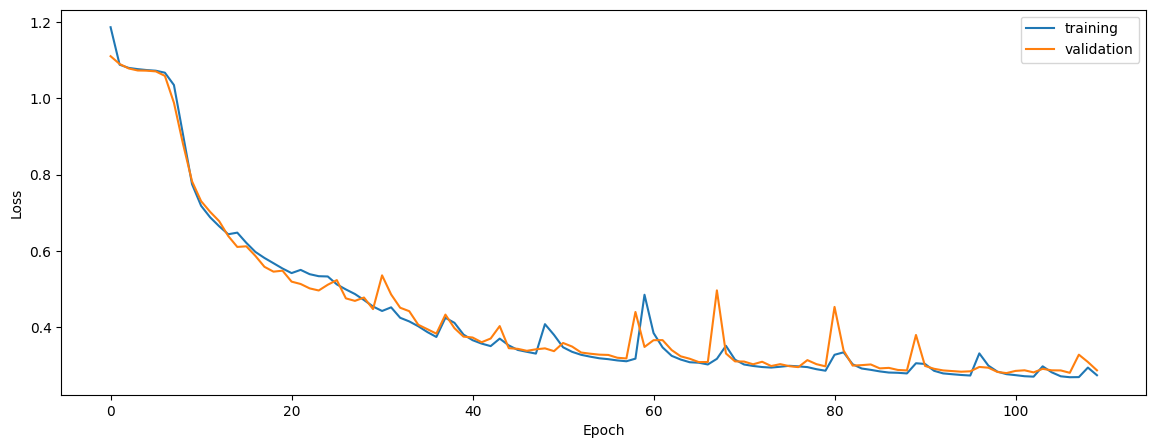

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8941104386026394


0.8941785235507833


0.8756949753283758


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.8974171251067059


0.9012293128107335


0.8764728941360943


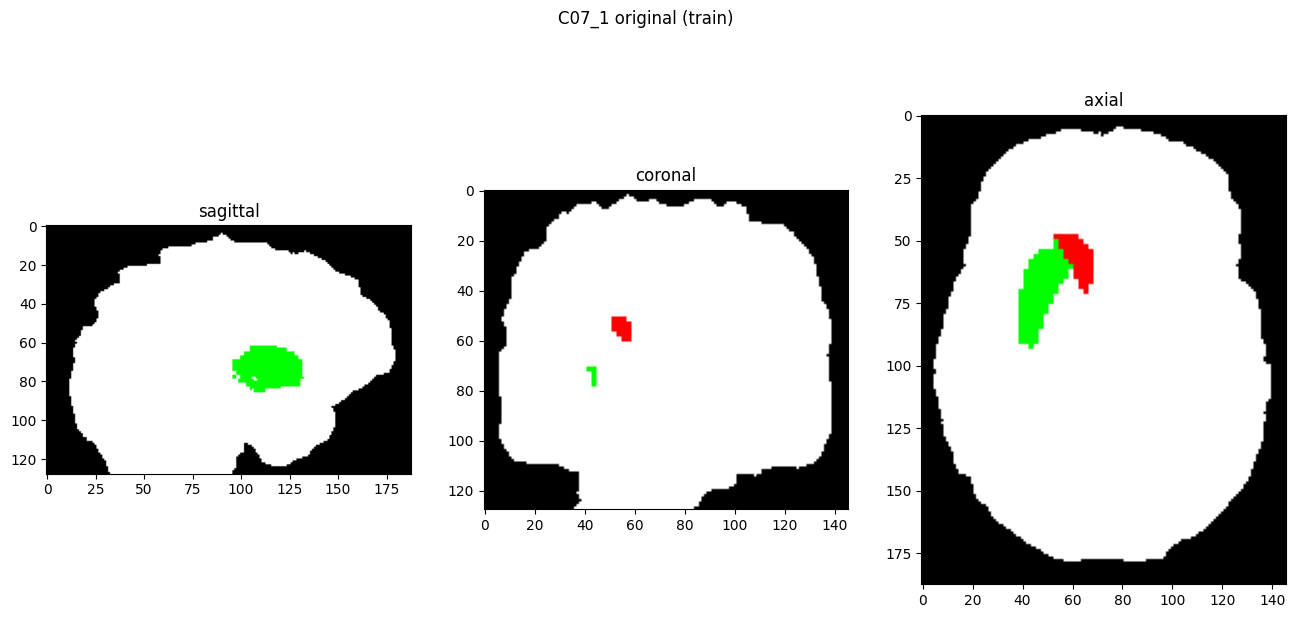

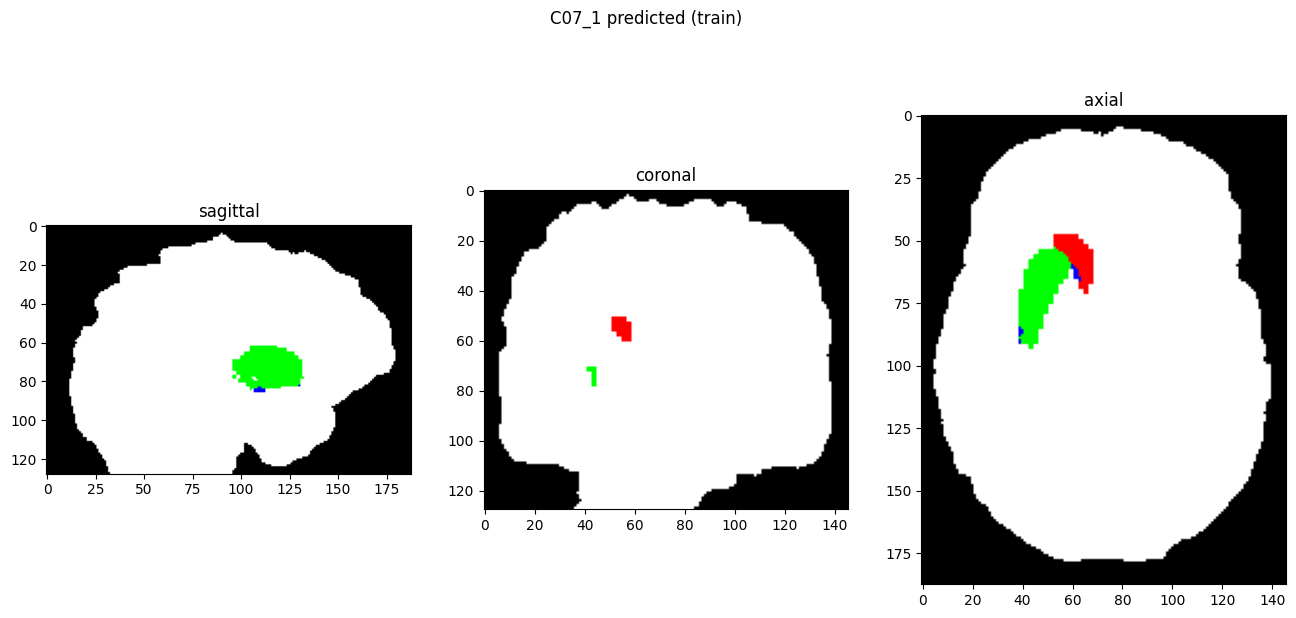

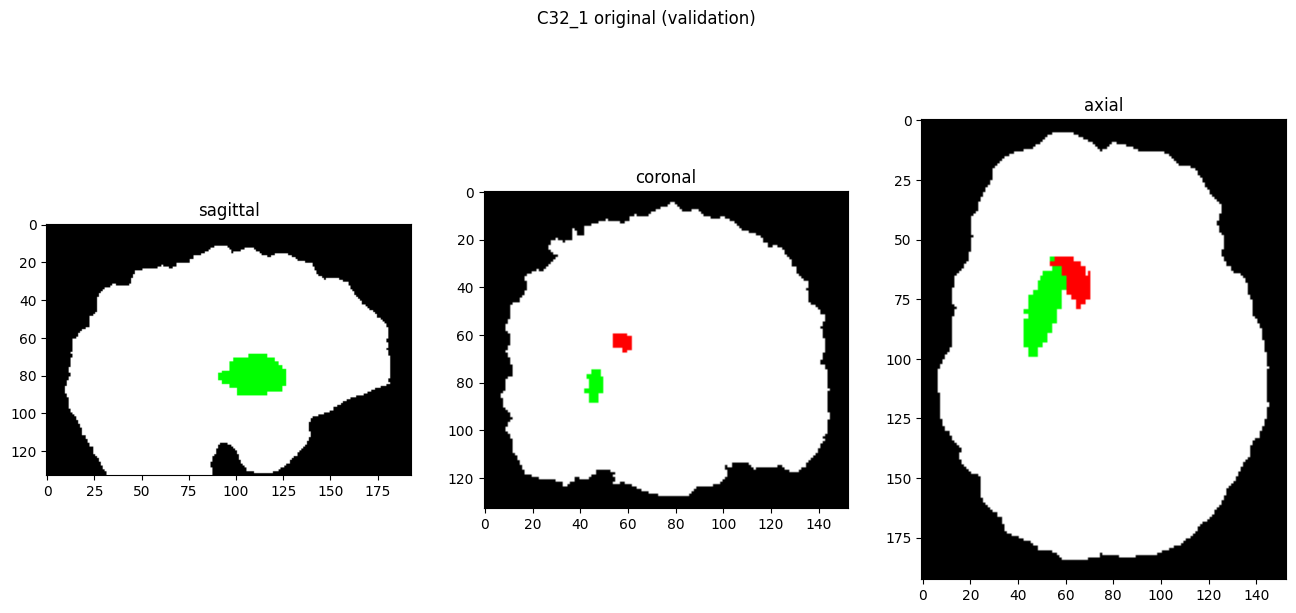

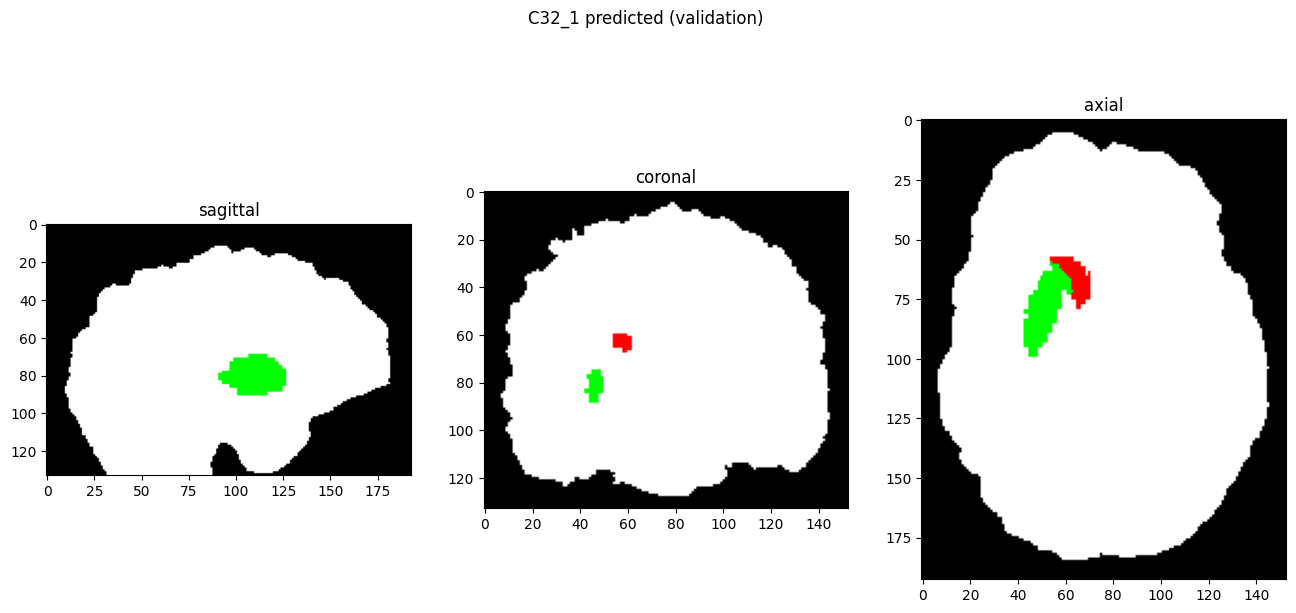

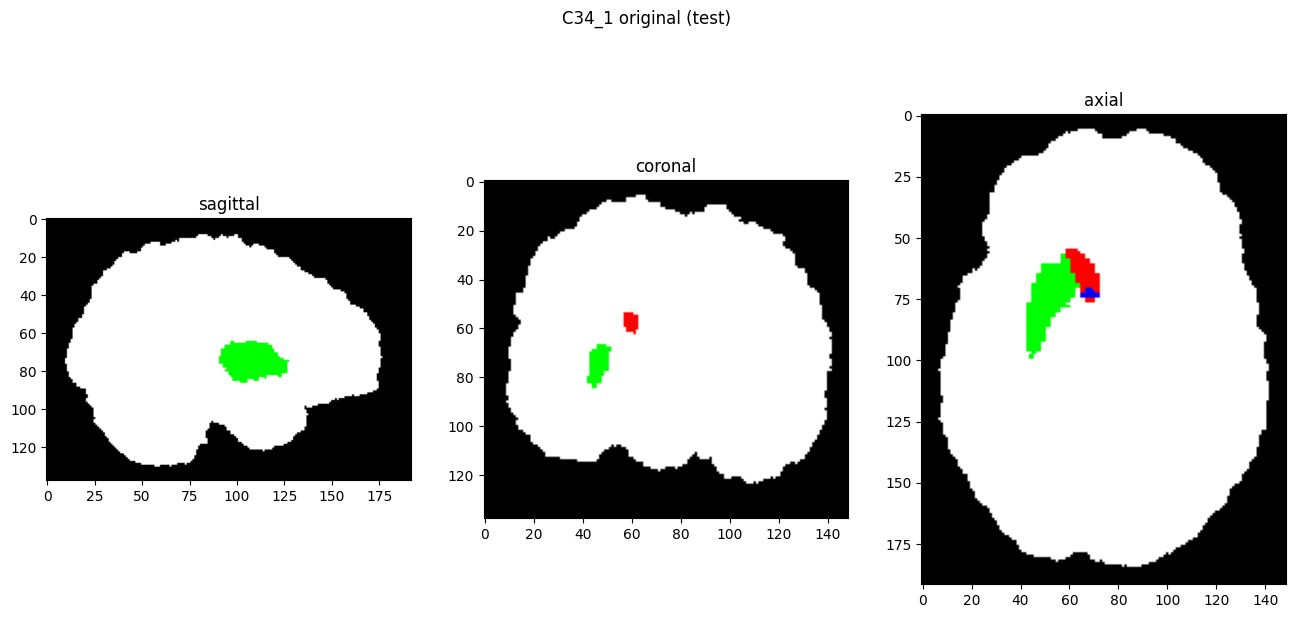

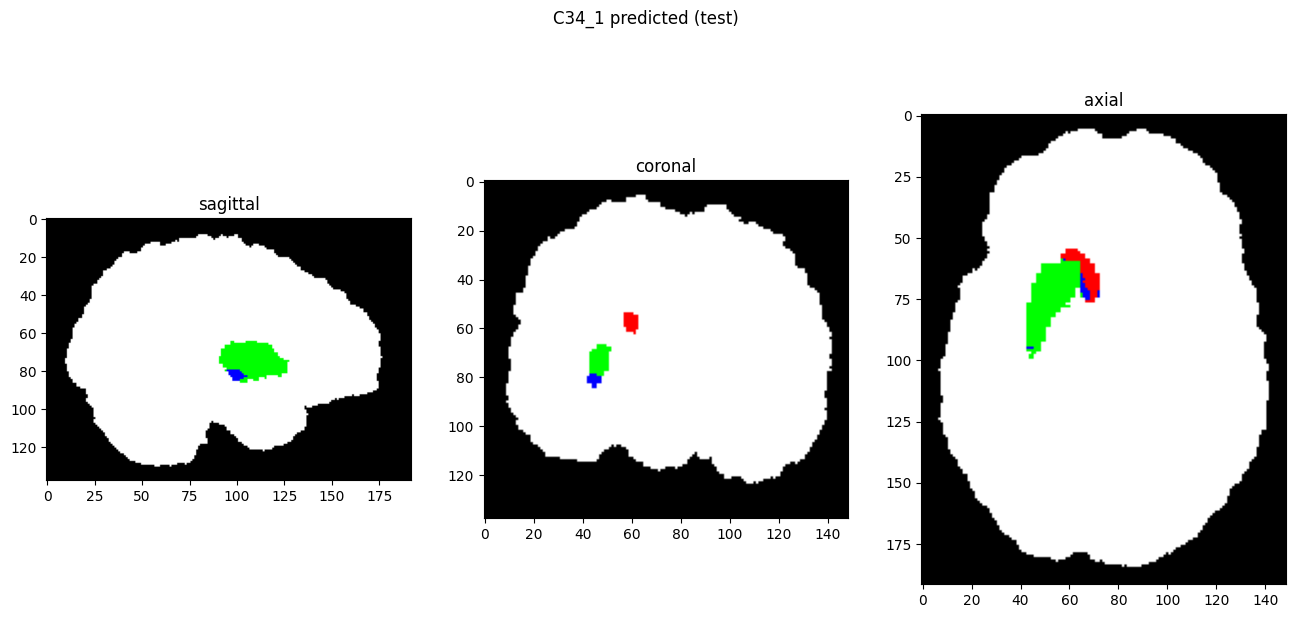

In [9]:
showResults(model, gen, threshold=0)